# Step 5 + 6: Modeling and Evaluation


## Table of Contents

1. [BI Ass2 Task 4: Modeling](#BI-Ass2-Task-4:-Modeling)
   - [1. Suitable Algorithms](#1.-Suitable-Algorithms)
   - [2. Hyperparameters](#2.-Hyperparameters)
   - [Train-Validation-Test split](#Train-Validation-Test-split)
   - [Model training](#Model-training)
   - [Performance metrics](#Performance-metrics)
2. [BI Ass2 Task 5: Evaluation](#BI-Ass2-Task-5:-Evaluation)
   - [Model Performance Evaluation: Training Data Only](#Model-Performance-Evaluation:-Training-Data-Only)
   - [Model Performance Evaluation: Training and Validation Data Combined](#Model-Performance-Evaluation:-Training-and-Validation-Data-Combined)
   - [Baseline Metrics](#Baseline-Metrics)
   - [Bias Analysis](#Bias-Analysis)

# BI Ass2 Task 4: Modeling

(4) Modeling (Responsible: A) 
1. Identify suitable data mining algorithms and select one of these as the most suitable for your 
experiments, providing a justification for the selection.  
2. Identify the hyper-parameters available for tuning in your chosen model and select one that 
you deem most relevant for tuning, providing a justification. 
3. Define and document a train / validation / test set split, considering where necessary 
appropriate stratification, any dependencies between data instances (e.g. time series data) 
and relative sizes of the respective subsets.  
4. Train the model on the training set and compare the performance on the validation set to 
identify the best hyper-parameter setting, explicitly documenting all parameter settings 
tested (avoid stating simply to have used “default parameters”, focus on reproducibility of the 
results you report).  
5. Report suitable performance metrics supported, where possible, by figures/graphs showing 
the tuning process of the hyper parameter. 

## 1. Suitable Algorithms

There is a large collection of traditional and modern machine learning models that can be used for the task at hand (life expectancy regression with tabular data). 

One model family in particular has seen much attention in previous years in machine learning competitions and industry, which are gradient boosted decision trees such as XGBoost. They are widely accepted as the recommended option in real-life tabular data problems. [https://doi.org/10.1016/j.inffus.2021.11.011]

More recently, researchers are working to close the gap between deep neural network approaches and gradient boosted decision trees for tabular data with some success. The idea is to introduce neural network architectures that are especially suitable for said data type. [https://doi.org/10.1609/aaai.v35i8.16826, https://arxiv.org/abs/2106.01342]

However, Ravid Shwartz-Ziv and Amitai Armon [https://doi.org/10.1016/j.inffus.2021.11.011] point out that deep neural network approaches for tabular data are to be taken with a grain of salt, since they are more challenging to optimize on a new dataset in comparison with XGBoost. Because of this, we decide to stick with gradient boosted decision tree models in this project, inparticular the gradient boosting regressor.

## 2. Hyperparameters

The gradient boosting regressor combines the strenghts of decision tree ensambling and gradient descent, leading to a wide variety of hyperparameters controlling this process.

The most widely used hyperparameters are:
- learning rate: Controls the contribution of a new tree's predictions to the existing model's predicitons
- number of estimators: The number of estimators/trees used in the prediction
- max depth: Maximum depth (number of splits) for each tree and thus controls overfitting
- loss function: The loss function used in gradient descent 
- Other parameters to control overfitting, like minimum number of samples to perform a split or in a leaf node.

We argue that the most direct impact on the learning process is exercised by: 
- learning rate, since it is the scaling factor by which the previous predictions are "moved" to minimize the loss
- number of estimators, since it controls the total number of iterations in which the model learns by adjusting previous predictions based on the gradient of the loss function
- max depth, since it controls the size of each tree and therefore model complexity (mainly to control overfitting)

We will varify this later on.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import plotly.subplots as sp
from plotly.graph_objects import Bar
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the dataframes
df_maxabs = pd.read_csv('./data_postprocessing/maxabs_scaled_df.csv')
df_minmax = pd.read_csv('./data_postprocessing/minmax_scaled_df.csv')
df_robust = pd.read_csv('./data_postprocessing/robust_scaled_df.csv')
df_standard = pd.read_csv('./data_postprocessing/standard_scaled_df.csv')
data = pd.read_csv('./data_postprocessing/data.csv')

In [3]:
data

,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,263.0,0.01,65.0,900.625,19.1,70,49.5,...,10.1,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,271.0,0.01,62.0,492.000,18.6,70,58.0,...,10.0,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,268.0,0.01,64.0,430.000,18.1,70,62.0,...,9.9,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,272.0,0.01,67.0,900.625,17.6,70,67.0,...,9.8,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,275.0,0.01,68.0,900.625,17.2,70,68.0,...,9.5,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.6,456.5,4.36,68.0,31.000,27.1,42,67.0,...,9.2,0,1,1,0,0,0,0,0,0
2934,Zimbabwe,2003,44.6,456.5,4.06,42.3,900.625,26.7,41,49.5,...,9.5,0,1,1,0,0,0,0,0,0
2935,Zimbabwe,2002,44.8,73.0,4.43,73.0,304.000,26.3,40,73.0,...,10.0,0,1,1,0,0,0,0,0,0
2936,Zimbabwe,2001,45.3,456.5,1.72,76.0,529.000,25.9,39,76.0,...,9.8,0,1,1,0,0,0,0,0,0


In [4]:
pd.set_option('display.max_columns', None)
df_maxabs.head()

,Country,Year,Life expectancy,Adult Mortality,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Income composition of resources,Schooling,Status_Developed,Status_Developing,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,Afghanistan,2015,65.0,0.576123,0.00058,0.656566,1.000000,0.218786,1.0,0.500000,0.670777,0.656566,0.054054,0.036797,1.000000,1.0,0.505274,0.510101,0,1,0,1,0,0,0,0,0
1,Afghanistan,2014,59.9,0.593647,0.00058,0.626263,0.546287,0.213058,1.0,0.585859,0.672421,0.626263,0.054054,0.038588,0.011782,1.0,0.502110,0.505051,0,1,0,1,0,0,0,0,0
2,Afghanistan,2013,59.9,0.587076,0.00058,0.646465,0.477446,0.207331,1.0,0.626263,0.668311,0.646465,0.054054,0.039787,1.000000,1.0,0.495781,0.500000,0,1,0,1,0,0,0,0,0
3,Afghanistan,2012,59.5,0.595838,0.00058,0.676768,1.000000,0.201604,1.0,0.676768,0.700370,0.676768,0.054054,0.042194,0.132962,1.0,0.488397,0.494949,0,1,0,1,0,0,0,0,0
4,Afghanistan,2011,59.2,0.602410,0.00058,0.686869,1.000000,0.197022,1.0,0.686869,0.646938,0.686869,0.054054,0.004002,0.107126,1.0,0.478903,0.479798,0,1,0,1,0,0,0,0,0


## Train-Validation-Test split

The data will be split randomly into three subsets for training, validation and testing while preserving the temporal component. This ensures that we can simulate testing the model performance trained on past data on future data. This is meaningful since a interesting use case will be the prediction of new data collected for a country for which you want to know what the expected life expectancy would be. We will take the first 11 years for the training set, the next three years as validation set and the last two years as test set, which corresponds roughly to a 70/20/10 split.

A decision against a true time series forecast for individual countries was made mainly due to the limited historical depth of the dataset, with only about 15 years for each country.

In [5]:
# Sort the dataframe by year
df_standard_sorted = df_standard.sort_values(by='Year')

# Split the data into training, validation, and test sets
train = df_standard_sorted[(df_standard_sorted['Year'] >= 2000) & (df_standard_sorted['Year'] <= 2010)]
val = df_standard_sorted[(df_standard_sorted['Year'] >= 2011) & (df_standard_sorted['Year'] <= 2013)]
test = df_standard_sorted[(df_standard_sorted['Year'] >= 2014) & (df_standard_sorted['Year'] <= 2015)]

# Randomly shuffle the data within each set
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
val = val.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the 'Year' column of the training set and transform
train['Year'] = scaler.fit_transform(train[['Year']])

# Transform the 'Year' column of the validation and test sets
val['Year'] = scaler.transform(val[['Year']])
test['Year'] = scaler.transform(test[['Year']])

# Display the first few rows of each set to verify
print("Training Set:")
print(train.head())
print("\nValidation Set:")
print(val.head())
print("\nTest Set:")
print(test.head())

Training Set:
              Country      Year  Life expectancy  Adult Mortality   Alcohol  \
0        Sierra Leone  0.632456             45.3        -1.012857 -0.190541   
1             Belarus -0.948683             67.2         0.866438  1.926135   
2  Russian Federation -0.948683             64.8         1.308116  1.582207   
3          Kyrgyzstan  0.632456             67.2         0.580647 -0.466190   
4              Guyana -0.948683             65.3         0.710552  0.788137   

   Hepatitis B   Measles       BMI  under-five deaths     Polio  \
0    -1.127311 -0.661135 -1.815232           1.073195 -1.414348   
1     0.879840 -0.621536  0.848828          -0.673514  0.863130   
2    -0.123735  0.979358  0.808691           0.239539  0.736604   
3     0.601069 -0.547997  0.031047          -0.554420  0.546814   
4     0.433807 -0.661135 -0.064277          -0.673514  0.483551   

   Total expenditure  Diphtheria  HIV/AIDS       GDP  Population  \
0          -2.054800   -1.349243  1.8950

In [6]:
# Calculate the total number of samples
total_samples = len(df_standard)

# Calculate the number of samples in each set
train_samples = len(train)
validation_samples = len(val)
test_samples = len(test)

# Calculate the proportion of each set
train_proportion = train_samples / total_samples
validation_proportion = validation_samples / total_samples
test_proportion = test_samples / total_samples

# Print the proportions
print(f"Train set proportion: {train_proportion:.2%}")
print(f"Validation set proportion: {validation_proportion:.2%}")
print(f"Test set proportion: {test_proportion:.2%}")

Train set proportion: 68.52%
Validation set proportion: 19.03%
Test set proportion: 12.46%


## Model training

### Hyperparameters

First, we evaluate the hyperparameter importances of learning rate, number of estimators and max depth. At this stage, we will not save all the used hyperparameter combinations since the goal is a rough estimate of their importance. We will do this when optimizing the chosen hyperparameter.

In [7]:
# Define the target and features for the training, validation, and test sets
X_train = train.drop(columns=['Life expectancy', 'Country'])
y_train = train['Life expectancy']

X_val = val.drop(columns=['Life expectancy', 'Country'])
y_val = val['Life expectancy']

X_test = test.drop(columns=['Life expectancy', 'Country'])
y_test = test['Life expectancy']

# Combine train and validation sets for cross-validation
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Define the model
gbr = GradientBoostingRegressor()

# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.25),
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6)
}

# Set up the randomized search
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

# Fit the randomized search to the training data
random_search.fit(X_train_val, y_train_val)

# Convert the results to a DataFrame
results = pd.DataFrame(random_search.cv_results_)

In [8]:
# Extract the hyperparameter values and mean test scores
learning_rates = results['param_learning_rate']
n_estimators = results['param_n_estimators']
max_depths = results['param_max_depth']
mean_test_scores = results['mean_test_score']

# Calculate the variance in performance explained by each hyperparameter
learning_rate_importance = np.var(mean_test_scores.groupby(learning_rates).mean())
n_estimators_importance = np.var(mean_test_scores.groupby(n_estimators).mean())
max_depth_importance = np.var(mean_test_scores.groupby(max_depths).mean())

# Print the importance of each hyperparameter
print(f"Learning rate importance: {learning_rate_importance}")
print(f"Number of estimators importance: {n_estimators_importance}")
print(f"Max depth importance: {max_depth_importance}")

Learning rate importance: 0.037843394696977714
Number of estimators importance: 0.025700408730299915
Max depth importance: 0.01108385804110385


In line with the highest feature parameter importance (in this case the highest proportion of variance in the model performance explained by a hyperparameter), we will continue with optimizing the hyperparameter learning rate.

In [9]:
# Define the model
gbr = GradientBoostingRegressor()

# Define the parameter distribution for learning rate
param_dist = {
    'learning_rate': uniform(0.01, 0.25)  # Uniform distribution between 0.01 and 0.2
}

scoring = {
    'R2': 'r2',
    'RMSE': make_scorer(mean_squared_error, squared=False)
}

# Set up the randomized search
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, n_iter=100, cv=5, scoring=scoring, refit='R2', n_jobs=-1, random_state=42)

# Fit the randomized search to the training data
random_search.fit(X_train_val, y_train_val)

# Get the best learning rate
best_learning_rate = random_search.best_params_['learning_rate']
print(f"Optimal learning rate: {best_learning_rate}")

Optimal learning rate: 0.24722138431333332


We proceed to train the model with the identified optimal learning rate stored in best_learning_rate

In [10]:
# Define the model with the optimal learning rate
gbr = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)

# Train the model on the training set
gbr.fit(X_train, y_train)

# Validate the model on the validation set
val_predictions = gbr.predict(X_val)

# Calculate the R^2 score
r2_score = gbr.score(X_val, y_val)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Print the validation scores
print(f"Validation R^2 Score: {r2_score:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation R^2 Score: 0.9116
Validation RMSE: 2.5393


## Performance metrics

The Coefficient of variance R^2 and the Root Mean Squared Error RMSE offer a great insight into the model performance. The R^2 explains how much of the variance in the target life expectancy is explained by the model, in this case about 91.5%. The RMSE is the square root of the average difference between the true values and predictions and it is conveniently in the same unit as the target variable, in this case year of life expectancy. That means that the average error we made in our predictions was about 2.5 years.

    param_learning_rate  mean_test_R2  mean_test_RMSE
0              0.103635      0.938448        2.325778
1              0.247679      0.945291        2.176870
2              0.192998      0.944692        2.193651
3              0.159665      0.942355        2.244709
4              0.049005      0.926778        2.541813
..                  ...           ...             ...
95             0.133449      0.942105        2.252236
96             0.140683      0.941571        2.259865
97             0.116885      0.939605        2.302845
98             0.016355      0.854686        3.606936
99             0.036973      0.919598        2.664432

[100 rows x 3 columns]


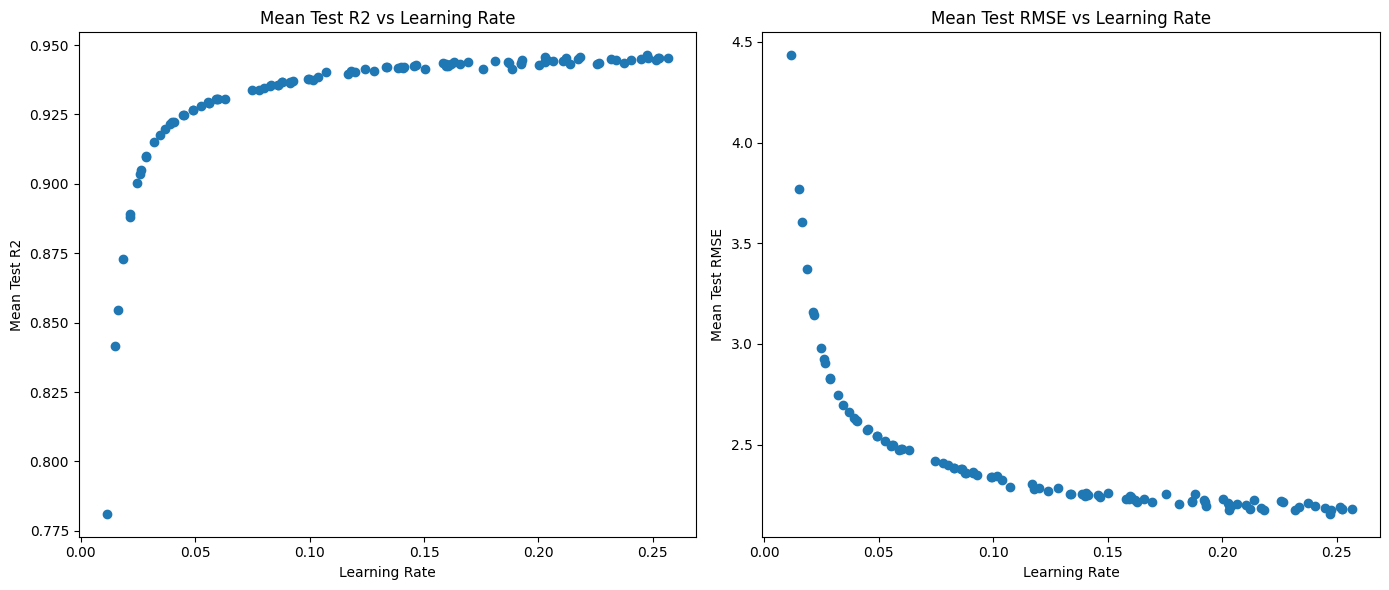

In [11]:
# Convert the results to a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the tried hyperparameters and their corresponding scores
tried_params_and_scores = results[['param_learning_rate', 'mean_test_R2', 'mean_test_RMSE']]
print(tried_params_and_scores)

# Plot the results
plt.figure(figsize=(14, 6))

# Plot mean_test_R2
plt.subplot(1, 2, 1)
plt.plot(tried_params_and_scores['param_learning_rate'], tried_params_and_scores['mean_test_R2'], 'o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test R2')
plt.title('Mean Test R2 vs Learning Rate')

# Plot mean_test_RMSE
plt.subplot(1, 2, 2)
plt.plot(tried_params_and_scores['param_learning_rate'], tried_params_and_scores['mean_test_RMSE'], 'o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test RMSE')
plt.title('Mean Test RMSE vs Learning Rate')

plt.tight_layout()
plt.show()

A clear relationship between higher learning rates and higher R2 scores/lower errors can be observed, with the prediction performance growing quite fast until a learning rate of about 0.05 is reached and slower after that point.

# BI Ass2 Task 5: Evaluation

(5) Evaluation (Responsible: B) 
1. Apply the final model on the test data and document performance. 
2. Re-train the model with identical hyper-parameters using the full train and validation data and again apply it on the test data, documenting and reflecting on the performance. 
3. Identify and document <br>
  i) state-of-the-art performance, i.e. the performance obtained by others using the same (albeit potentially slightly differently pre-processed) data set as reported in literature (preferably in peer-reviewed papers, in absence of these grey literature or internet publications are fine well). If no baseline performance can be identified for your task, report on other analyses/tasks using the same dataset. <br>
ii) expected base-line performance of a trivial acceptor / rejecter or random classifier 
4. Compare the performance achieved with the benchmark and baseline performances 
according to different metrics (i.e. overall, but also on per-class level (confusion matrix), 
micro/macro precision/recall in the case of classification tasks, regression errors in certain 
parts of the data space, … (Note your goal is not necessarily to obtain a better result than 
what has been reported in the state of the art, this is not a grading criterion! On the other 
hand, if the performance of your classifiers is below a random baseline or trivial acceptor 
/ rejecter you may want to investigate the reason…) 
5. Compare the performance obtained with the success criteria defined in the Business Understanding phase. 
6. Identify a “protected attribute” and evaluate whether the model exhibits a bias 
towards that group. The attribute can be one that may be considered sensitive or – in 
absence of any actually sensitive attributes – any attribute that identifies a subgroup of the 
data for which you may want to identify skewed performance of the model. 

## Model Performance Evaluation: Training Data Only
#### *1. Apply the final model on the test data and document performance.* 

### Objective
The objective of this analysis was to assess the performance of the Gradient Boosting Regressor model, trained on historical data from 2000 to 2010, when applied to the test dataset spanning the years 2014 to 2015.

### Method
The model's predictive accuracy was evaluated using the following metrics:
- **R² Score (Coefficient of Determination)**: Indicates the proportion of variance in the dependent variable predictable from the independent variables.
- **Root Mean Squared Error (RMSE)**: Reflects the average magnitude of the prediction errors.
- **Mean Squared Error (MSE)**: Measures the average squared difference between actual and predicted values, penalizing larger errors more heavily.
- **Mean Absolute Error (MAE)**: Represents the average magnitude of the errors in a more interpretable linear scale.


In [12]:
# Train the model on the training set
gbr.fit(X_train, y_train)

# Predict on the test set
test_predictions = gbr.predict(X_test) 

# Calculate the R² score on the test set
test_r2_score = gbr.score(X_test, y_test)  

# Calculate the root mean squared error (RMSE) on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# # Print the test scores
# print(f"Test R² Score: {test_r2_score:.4f}")
# print(f"Test RMSE: {test_rmse:.4f}")

# Calculate MAE and MSE
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# Print all performance metrics
print(f"Final Model Performance on Test Data:")
print(f"- R² Score: {test_r2_score:.4f}")
print(f"- RMSE: {test_rmse:.4f}")
print(f"- MAE: {test_mae:.4f}")
print(f"- MSE: {test_mse:.4f}")

Final Model Performance on Test Data:
- R² Score: 0.8941
- RMSE: 2.7080
- MAE: 2.0483
- MSE: 7.3330


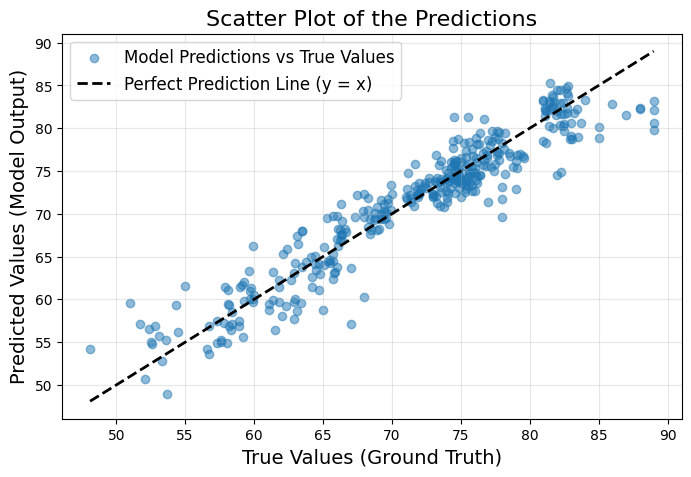

In [13]:
# Create scatter plot with clearer labels and descriptions
plt.figure(figsize=(8, 5))

# Scatter plot with adjusted labels
plt.scatter(y_test, test_predictions, alpha=0.5, label="Model Predictions vs True Values")

# Diagonal line for ideal predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Prediction Line (y = x)")

# Updated axis labels
plt.xlabel('True Values (Ground Truth)', fontsize=14)
plt.ylabel('Predicted Values (Model Output)', fontsize=14)

# Updated title
plt.title('Scatter Plot of the Predictions', fontsize=16)

# Improved legend for clarity
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.3)

# Save the plot as an SVG
# plt.savefig("actual_vs_predicted.svg", format='svg')


#### Visualization of Model Performance

This section provides two key visualizations to evaluate the performance of the model:

1. **Residuals Plot**: This scatter plot shows the relationship between the predicted values and the residuals (difference between actual and predicted values). A random, evenly distributed spread around the horizontal zero line indicates that the model's predictions are unbiased.

2. **Histogram of Residuals**: This histogram displays the distribution of the residuals. A symmetric and bell-shaped residual distribution centered around zero suggests that the model has captured the overall trend effectively without systematic errors.

These visualizations help to:
- Assess whether the residuals are randomly distributed.
- Identify potential patterns, biases, or outliers in the predictions.


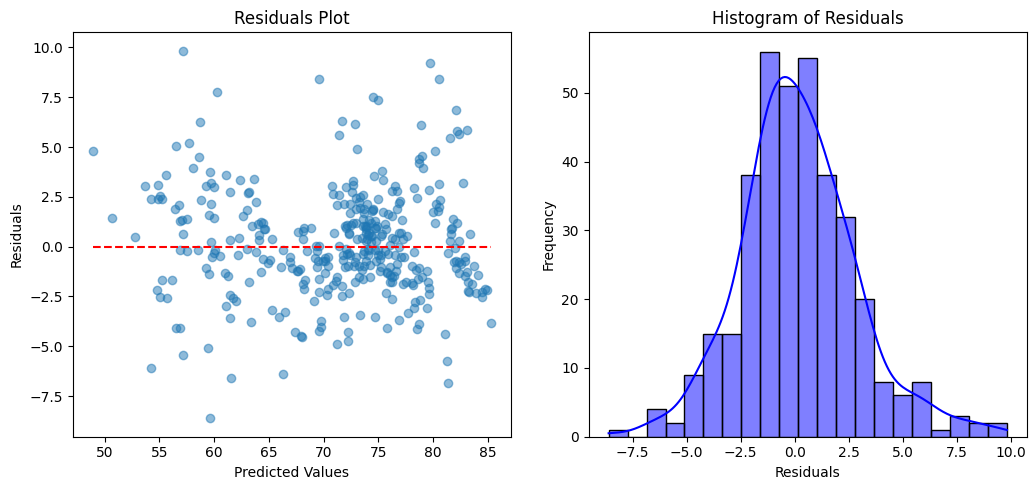

In [14]:
# Visualization of Actual vs Predicted values
plt.figure(figsize=(15, 5))

# Scatter plot for actual vs predicted
# plt.subplot(1, 3, 1)
# plt.scatter(y_test, test_predictions, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')

# Plot of Residuals
plt.subplot(1, 3, 2)
residuals = y_test - test_predictions
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.hlines(y=0, xmin=test_predictions.min(), xmax=test_predictions.max(), colors='red', linestyles='--')  # Zero line for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Histogram of Residuals
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Correlation and Feature Importance Analysis

This section combines feature correlations with the target variable and model-derived feature importances to evaluate the relationship between features and their predictive power.

#### Steps:
1. **Correlation Analysis**:  
   - All numeric columns, including \texttt{Year} and encoded \texttt{Continent} features, are used to compute their correlation with the target variable.
   - A correlation matrix is generated, and correlations with the target variable are extracted and sorted for clarity.

2. **Feature Importance**:  
   - The model's feature importances are filtered to ensure they align with the numeric columns used in the correlation analysis.
   - These feature importances reflect the relative contribution of each feature in the predictive model.

3. **Combining Results**:  
   - A table is created that combines the correlation values and feature importances for each numeric feature. This allows for a comparison between statistical correlation and the model's reliance on each feature.

4. **Visualization**:  
   - A horizontal bar plot is generated to display:
     - Correlation values with the target variable.
     - Feature importances as determined by the Gradient Boosting Regressor.  
   - The visualization highlights discrepancies or alignments between statistical correlation and predictive importance, aiding in feature analysis and interpretation.

#### Key Insights:
- Features with high correlation but low importance may indicate redundancy or multicollinearity.
- Features with high importance but low correlation suggest that the model identifies nonlinear or complex relationships that standard correlation analysis may not capture.



Feature Correlations and Importances:
                            Feature  Correlation_with_Target  Importance
0                            Target                 1.000000         NaN
1   Income composition of resources                 0.859263    0.180475
2                         Schooling                 0.776573    0.009414
3                             Polio                 0.555011    0.001617
4                        Diphtheria                 0.533422    0.016280
5                  Status_Developed                 0.517005    0.000000
6                  Continent_Europe                 0.493932    0.000065
7                               GDP                 0.493648    0.001019
8                               BMI                 0.491546    0.007533
9                       Hepatitis B                 0.437718    0.000689
10                          Alcohol                 0.376115    0.005219
11                Total expenditure                 0.224066    0.001414
12          

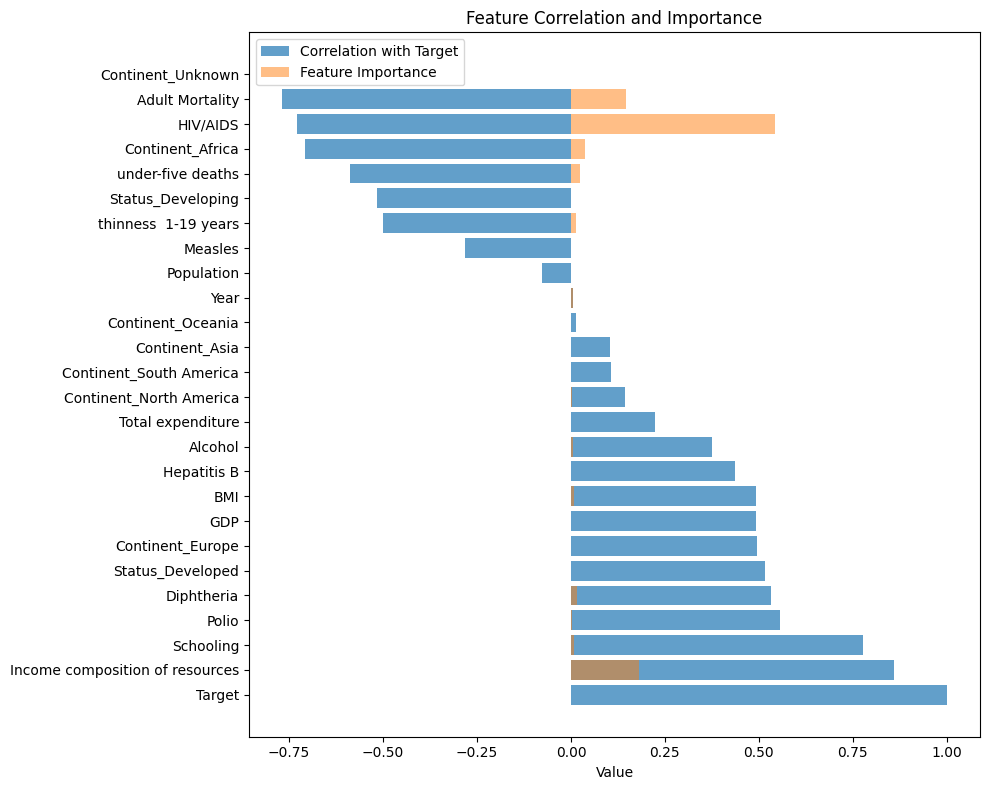

In [15]:
# Combine train and validation datasets
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Train the Gradient Boosting Regressor
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train_val, y_train_val)

# Use all numerical columns, including 'Year' and 'Continent' columns
numeric_columns = X_test.select_dtypes(include='number').columns

# Add the target variable to numeric columns for correlation analysis
correlation_df = X_test[numeric_columns].copy()
correlation_df['Target'] = y_test  # Add the target variable

# Compute the correlation matrix
correlation_matrix = correlation_df.corr()

# Extract correlations of all features with the target variable
target_correlations = correlation_matrix['Target'].sort_values(ascending=False)

# Filter model feature importances to include all numeric columns
filtered_feature_importances = [
    importance for feature, importance in zip(X_test.columns, model.feature_importances_) if feature in numeric_columns
]

# Combine feature importance and correlations
feature_importance_df = pd.DataFrame({
    "Feature": numeric_columns,
    "Importance": filtered_feature_importances
})

# Merge feature importance with correlations
correlation_importance_df = pd.DataFrame({
    "Correlation_with_Target": target_correlations
}).reset_index().rename(columns={"index": "Feature"}).merge(
    feature_importance_df,
    on="Feature",
    how="left"
).sort_values(by="Correlation_with_Target", ascending=False)

# Display the combined DataFrame as a table
print("\nFeature Correlations and Importances:")
print(correlation_importance_df)

# Plot Correlation with Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(
    correlation_importance_df['Feature'],
    correlation_importance_df['Correlation_with_Target'],
    alpha=0.7,
    label='Correlation with Target'
)
plt.barh(
    correlation_importance_df['Feature'],
    correlation_importance_df['Importance'],
    alpha=0.5,
    label='Feature Importance'
)
plt.xlabel('Value')
plt.title('Feature Correlation and Importance')
plt.legend()
plt.tight_layout()
plt.show()


#### Feature Importance


Feature Importance for All Features:
                            Feature  Importance
10                         HIV/AIDS    0.543919
14  Income composition of resources    0.180475
1                   Adult Mortality    0.145387
18                 Continent_Africa    0.036390
6                 under-five deaths    0.024994
9                        Diphtheria    0.016280
13             thinness  1-19 years    0.013825
15                        Schooling    0.009414
5                               BMI    0.007533
0                              Year    0.006267
2                           Alcohol    0.005219
21          Continent_North America    0.002720
7                             Polio    0.001617
8                 Total expenditure    0.001414
11                              GDP    0.001019
12                       Population    0.000997
3                       Hepatitis B    0.000689
4                           Measles    0.000575
17                Status_Developing    0.000524
19

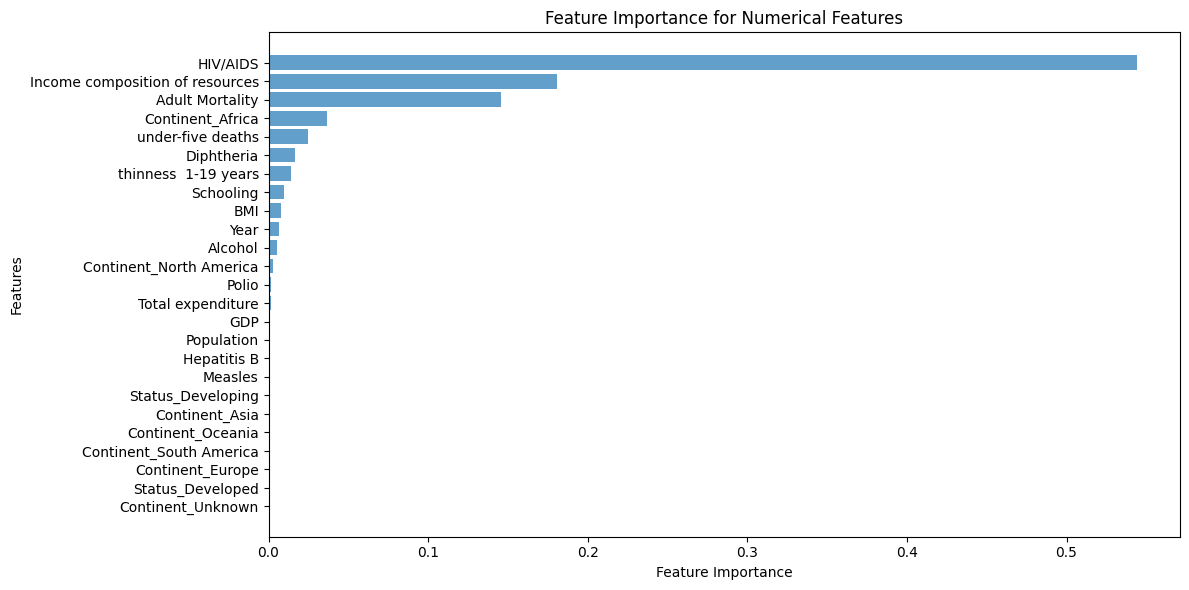

In [16]:
# Print all feature importances
all_feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance for All Features:")
print(all_feature_importance_df)

# Filter numeric columns from X_test, including 'Continent' columns and 'Year'
numerical_columns = X_test.select_dtypes(include='number').columns

# Filter feature importances to match the filtered numerical columns
filtered_feature_importances = [
    importance for feature, importance in zip(X_test.columns, model.feature_importances_) if feature in numerical_columns
]

# Create a DataFrame for filtered feature importance
feature_importance_df = pd.DataFrame({
    "Feature": numerical_columns,
    "Importance": filtered_feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot the feature importance for filtered features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], alpha=0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Numerical Features")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()
plt.show()

### Feature Importance Analysis by Continent

This section evaluates the feature importance for each continent by training separate models on continent-specific data.

#### Steps:
1. **Data Segmentation**:  
   The training data is filtered to isolate subsets corresponding to each continent using one-hot encoded continent columns.

2. **Model Training**:  
   A Gradient Boosting Regressor is independently trained for each continent. Continents with fewer than 10 samples are skipped to ensure model reliability.

3. **Feature Importance Extraction**:  
   After training, the feature importances for each continent-specific model are recorded.

4. **Results Compilation**:  
   The feature importance values are organized into a DataFrame, where each column represents a continent, and rows correspond to features.

#### Output:  
- A table displaying the feature importances for each continent.
- Insights into regional differences in feature relevance, highlighting how predictors vary across continents.


In [17]:
# Initialize a dictionary to store feature importance for each continent
continent_feature_importance = {}

# Get unique continents from the dataset
continents = [col for col in X_train.columns if "Continent_" in col]

# Loop through each continent
for continent in continents:
    # Create a mask for the current continent using the training data
    continent_mask = X_train[continent] == 1
    
    # Filter the data for the current continent
    X_train_continent = X_train[continent_mask]
    y_train_continent = y_train[continent_mask]
    
    # Check if there is sufficient data to train
    if len(X_train_continent) < 10:  # Skip if too few samples
        print(f"Skipping {continent} due to insufficient data.")
        continue
    
    # Train a separate model for the continent
    model = GradientBoostingRegressor(learning_rate= best_learning_rate, random_state=42)
    model.fit(X_train_continent, y_train_continent)
    
    # Store feature importance
    continent_feature_importance[continent] = model.feature_importances_

# Convert the results into a DataFrame for easier interpretation
importance_df = pd.DataFrame(continent_feature_importance, index=X_train.columns)
importance_df = importance_df.reset_index().rename(columns={"index": "Feature"})

# Print the DataFrame
print("\nFeature Importance by Continent:")
print(importance_df)


Skipping Continent_Unknown due to insufficient data.

Feature Importance by Continent:
                            Feature  Continent_Africa  Continent_Asia  \
0                              Year          0.030762        0.001445   
1                   Adult Mortality          0.246197        0.568981   
2                           Alcohol          0.009944        0.013468   
3                       Hepatitis B          0.002255        0.002881   
4                           Measles          0.001023        0.001246   
5                               BMI          0.010001        0.004562   
6                 under-five deaths          0.048533        0.007178   
7                             Polio          0.019767        0.009928   
8                 Total expenditure          0.015278        0.003279   
9                        Diphtheria          0.028213        0.013056   
10                         HIV/AIDS          0.525085        0.002845   
11                              GDP  

#### Visualization of the Feature Importance by Continent

In [18]:
# Prepare the data for visualization
importance_df_melted = importance_df.melt(id_vars="Feature", var_name="Continent", value_name="Importance")

# Create an interactive Plotly line plot
fig = px.line(
    importance_df_melted,
    x="Feature",
    y="Importance",
    color="Continent",
    markers=True,
    title="Feature Importance by Continent"
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Feature",
    yaxis_title="Feature Importance",
    xaxis=dict(tickangle=45),
    legend_title="Continent",
    template="plotly_white"
)

# Show the interactive plot
fig.show()


#### Top 3 Feature Importances of each Continent

In [19]:
# Sort and filter top features per continent
top_features_per_continent = (
    importance_df_melted.groupby("Continent")
    .apply(lambda df: df.nlargest(3, "Importance"))
    .reset_index(drop=True)
)

# Prepare a subplot for each continent
continents = top_features_per_continent['Continent'].unique()
fig = sp.make_subplots(
    rows=len(continents),
    cols=1,
    subplot_titles=continents,
    vertical_spacing=0.1
)

# Add each continent's features to its own subplot
for i, continent in enumerate(continents, start=1):
    continent_data = top_features_per_continent[top_features_per_continent['Continent'] == continent]
    fig.add_trace(
        Bar(
            x=continent_data["Importance"],
            y=continent_data["Feature"],
            orientation="h",
            name=continent
        ),
        row=i,
        col=1
    )

# Update layout for compactness
fig.update_layout(
    title="Top 3 Feature Importances by Continent (Compact)",
    height=300 * len(continents),  # Adjust height based on number of subplots
    showlegend=False,  # Hide legend (subplot titles suffice)
    template="plotly_white"
)

# Customize axes
fig.update_xaxes(title_text="Feature Importance")
fig.update_yaxes(title_text="Feature", automargin=True)

# Show the plot
fig.show()


<Figure size 800x600 with 0 Axes>

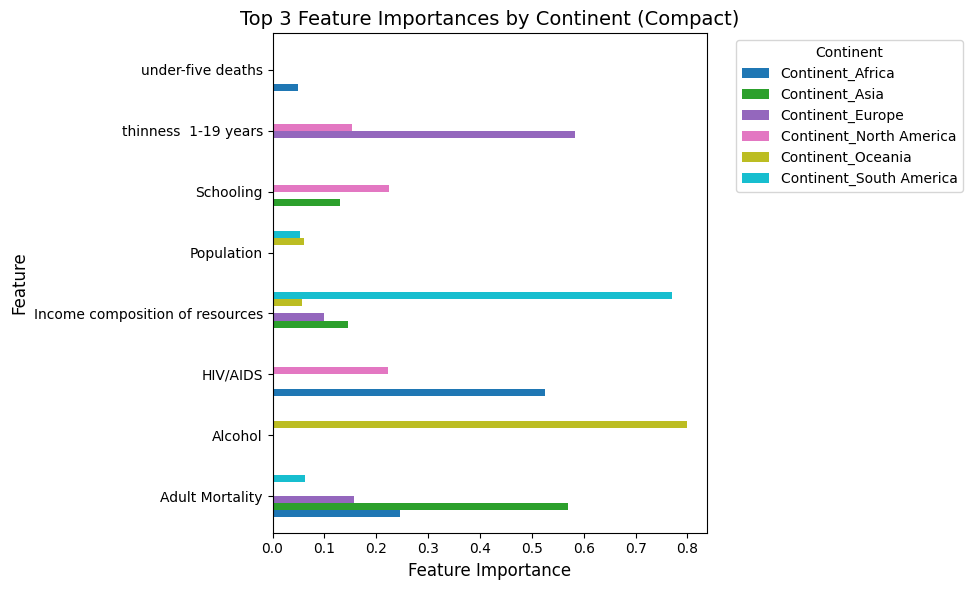

In [20]:
# Filter and prepare the data for grouped bar chart
top_features_per_continent = (
    importance_df_melted.groupby("Continent")
    .apply(lambda df: df.nlargest(3, "Importance"))
    .reset_index(drop=True)
)

# Create a pivot table for grouped bar chart
pivot_df = top_features_per_continent.pivot(index="Feature", columns="Continent", values="Importance")

# Plotting
plt.figure(figsize=(8, 6))  # Compact size suitable for reports
pivot_df.plot(kind="barh", stacked=False, figsize=(10, 6), width=0.7, cmap="tab10")

# Customize the plot
plt.title("Top 3 Feature Importances by Continent (Compact)", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()

# Save as SVG (optional)
# plt.savefig("top_features_by_continent.svg", format="svg")

# Show the plot
plt.show()


In [21]:
# Check that test dataset has continent information properly formatted
if 'Continent' not in X_test.columns:
    continent_columns = [
        'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
        'Continent_North America', 'Continent_Oceania', 'Continent_South America'
    ]
    X_test['Continent'] = X_test[continent_columns].idxmax(axis=1).str.replace('Continent_', '')

# Create a DataFrame for feature importance by continent
feature_importance_by_continent = pd.DataFrame()

# Model feature importances (assumes the model is already trained)
original_features = X_test.drop(columns=['Continent']).columns
feature_importances = pd.DataFrame({
    'Feature': original_features,
    'Importance': model.feature_importances_
})

# Iterate through each continent and calculate feature importance
for continent in X_test['Continent'].unique():
    continent_mask = X_test['Continent'] == continent
    # Subset the X_test dataset for the current continent
    X_continent = X_test.loc[continent_mask, original_features]
    # Duplicate the importance values for each continent
    continent_importance = feature_importances.copy()
    continent_importance['Continent'] = continent
    feature_importance_by_continent = pd.concat([feature_importance_by_continent, continent_importance], ignore_index=True)

# Group by continent and get the top 3 features
top_features_by_continent = (
    feature_importance_by_continent.groupby('Continent')
    .apply(lambda group: group.nlargest(3, 'Importance'))
    .reset_index(drop=True)
)

# Display the DataFrame
pd.set_option('display.max_rows', None)  # Remove the limit on the number of rows displayed
print("\nTop 3 Relevant Features by Continent:")
print(top_features_by_continent)

# Reset the option if needed
pd.reset_option('display.max_rows')



Top 3 Relevant Features by Continent:
                            Feature  Importance      Continent
0   Income composition of resources    0.770924         Africa
1                   Adult Mortality    0.062795         Africa
2                        Population    0.053683         Africa
3   Income composition of resources    0.770924           Asia
4                   Adult Mortality    0.062795           Asia
5                        Population    0.053683           Asia
6   Income composition of resources    0.770924         Europe
7                   Adult Mortality    0.062795         Europe
8                        Population    0.053683         Europe
9   Income composition of resources    0.770924  North America
10                  Adult Mortality    0.062795  North America
11                       Population    0.053683  North America
12  Income composition of resources    0.770924        Oceania
13                  Adult Mortality    0.062795        Oceania
14              

In [22]:
# Initialize a dictionary to store feature importance for each continent
continent_feature_importance = {}

# Get unique continents from the dataset
continents = [col for col in X_train.columns if "Continent_" in col]

# Loop through each continent
for continent in continents:
    # Create a mask for the current continent using the training data
    continent_mask = X_train[continent] == 1
    
    # Filter the data for the current continent
    X_train_continent = X_train[continent_mask]
    y_train_continent = y_train[continent_mask]
    
    # Check if there is sufficient data to train
    if len(X_train_continent) < 10:  # Skip if too few samples
        print(f"Skipping {continent} due to insufficient data.")
        continue
    
    # Train a separate model for the continent
    model = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)
    model.fit(X_train_continent, y_train_continent)
    
    # Store feature importance
    continent_feature_importance[continent] = model.feature_importances_

# Convert the results into a DataFrame for easier interpretation
importance_df = pd.DataFrame(continent_feature_importance, index=X_train.columns)
importance_df = importance_df.reset_index().rename(columns={"index": "Feature"})

# Get the top 3 features for each continent
top_features = {}
for continent in continents:
    if continent in importance_df:
        top_features[continent] = (
            importance_df[['Feature', continent]]
            .sort_values(by=continent, ascending=False)
            .head(3)
            .rename(columns={continent: "Importance"})
        )

# Print the top 3 features for each continent
for continent, features in top_features.items():
    print(f"\nTop 3 Relevant Features for {continent.replace('Continent_', '')}:")
    print(features)


Skipping Continent_Unknown due to insufficient data.

Top 3 Relevant Features for Africa:
              Feature  Importance
10           HIV/AIDS    0.525085
1     Adult Mortality    0.246197
6   under-five deaths    0.048533

Top 3 Relevant Features for Asia:
                            Feature  Importance
1                   Adult Mortality    0.568981
14  Income composition of resources    0.145266
15                        Schooling    0.129754

Top 3 Relevant Features for Europe:
                            Feature  Importance
13             thinness  1-19 years    0.583559
1                   Adult Mortality    0.157890
14  Income composition of resources    0.098280

Top 3 Relevant Features for North America:
                 Feature  Importance
15             Schooling    0.225158
10              HIV/AIDS    0.222823
13  thinness  1-19 years    0.152702

Top 3 Relevant Features for Oceania:
                            Feature  Importance
2                           Alcohol    0

Print the Metrics for each Continent

In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# R2_score should not be overwritten
print(f"Type of r2_score: {type(r2_score)}") 

# Compare performance metrics by continent
for continent in X_test['Continent'].unique():
    mask = X_test['Continent'] == continent
    r2 = r2_score(y_test[mask], test_predictions[mask])  # Should now work correctly
    rmse = np.sqrt(mean_squared_error(y_test[mask], test_predictions[mask]))
    mae = mean_absolute_error(y_test[mask], test_predictions[mask])
    print(f"{continent} - R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Type of r2_score: <class 'function'>
Africa - R²: 0.7779, RMSE: 3.1020, MAE: 2.4407
North America - R²: 0.6498, RMSE: 2.2780, MAE: 1.8003
Asia - R²: 0.7716, RMSE: 2.5499, MAE: 1.8650
South America - R²: 0.7445, RMSE: 1.9835, MAE: 1.4576
Europe - R²: 0.5832, RMSE: 2.8868, MAE: 2.1584
Oceania - R²: 0.8988, RMSE: 1.8853, MAE: 1.5914


In [24]:
# Overall metrics
overall_mae = mean_absolute_error(y_test, test_predictions)
overall_mse = mean_squared_error(y_test, test_predictions)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y_test, test_predictions)

print(f"Overall MAE: {overall_mae}")
print(f"Overall MSE: {overall_mse}")
print(f"Overall RMSE: {overall_rmse}")
print(f"Overall R²: {overall_r2}")

# Segment-specific error analysis (e.g., by continent)
def calculate_segmented_errors(group):
    return {
        "MAE": mean_absolute_error(y_test[group.index], test_predictions[group.index]),
        "MSE": mean_squared_error(y_test[group.index], test_predictions[group.index]),
        "RMSE": np.sqrt(mean_squared_error(y_test[group.index], test_predictions[group.index])),
        "R²": r2_score(y_test[group.index], test_predictions[group.index])
    }

# Exclude the grouping columns explicitly
segmented_errors = X_test.drop(columns="Continent").groupby(X_test["Continent"]).apply(calculate_segmented_errors)

# Print the segmented error analysis
print("Segmented Error Analysis:")
for continent, metrics in segmented_errors.items():
    print(f"{continent}: MAE={metrics['MAE']:.4f}, MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Overall MAE: 2.04829805652809
Overall MSE: 7.333005882348438
Overall RMSE: 2.707952341225458
Overall R²: 0.894126984739145
Segmented Error Analysis:
Africa: MAE=2.4407, MSE=9.6224, RMSE=3.1020, R²=0.7779
Asia: MAE=1.8650, MSE=6.5018, RMSE=2.5499, R²=0.7716
Europe: MAE=2.1584, MSE=8.3339, RMSE=2.8868, R²=0.5832
North America: MAE=1.8003, MSE=5.1891, RMSE=2.2780, R²=0.6498
Oceania: MAE=1.5914, MSE=3.5545, RMSE=1.8853, R²=0.8988
South America: MAE=1.4576, MSE=3.9342, RMSE=1.9835, R²=0.7445


In [25]:
# Recreate a single 'Continent' column
continent_columns = [
    'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
    'Continent_North America', 'Continent_Oceania', 'Continent_South America', 'Continent_Unknown'
]

# Ensure only one dummy variable is 1 per row
if (X_test[continent_columns].sum(axis=1) != 1).any():
    raise ValueError("Dummy variables for continents are not properly one-hot encoded.")

X_test['Continent'] = X_test[continent_columns].idxmax(axis=1).str.replace('Continent_', '')

# Create a DataFrame to align predictions and actuals with the 'Continent' column
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Continent': X_test['Continent']
})

# Calculate R² scores for each continent
r2_scores_by_continent = results_df.groupby('Continent').apply(
    lambda group: r2_score(group['Actual'], group['Predicted'])
)

# Print R² scores
print("R² Scores by Continent:")
print(r2_scores_by_continent)


R² Scores by Continent:
Continent
Africa           0.777949
Asia             0.771569
Europe           0.583174
North America    0.649757
Oceania          0.898823
South America    0.744460
dtype: float64


In [26]:
# Create a DataFrame to align predictions and actuals with the 'Continent' column
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Continent': X_test['Continent']
})

print("Variance by Continent:")
print(results_df.groupby('Continent')['Actual'].var())


Variance by Continent:
Continent
Africa           43.739020
Asia             28.768863
Europe           20.253295
North America    15.177172
Oceania          36.980289
South America    16.065145
Name: Actual, dtype: float64


In [27]:
print(results_df['Continent'].value_counts())


Continent
Africa           108
Asia              94
Europe            78
North America     42
South America     24
Oceania           20
Name: count, dtype: int64


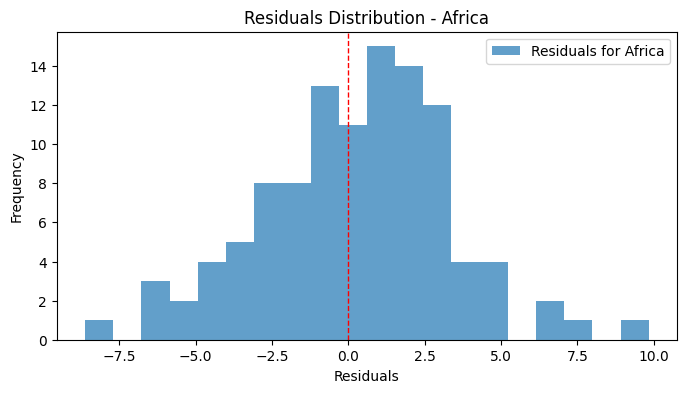

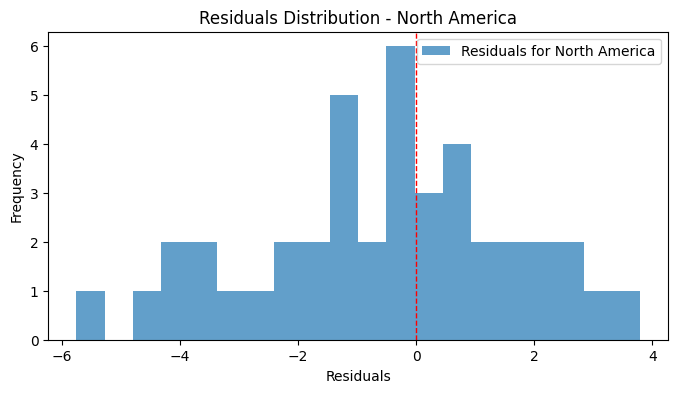

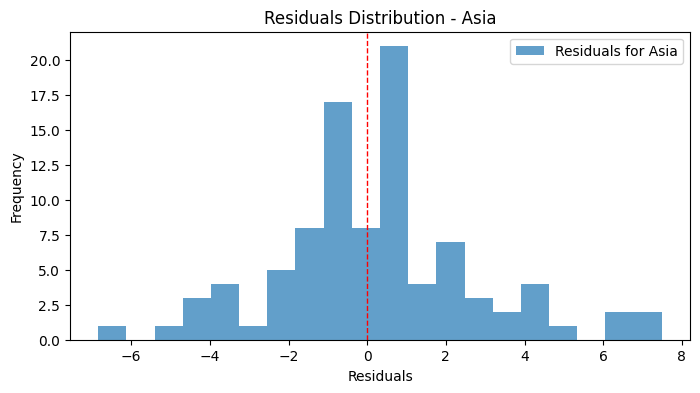

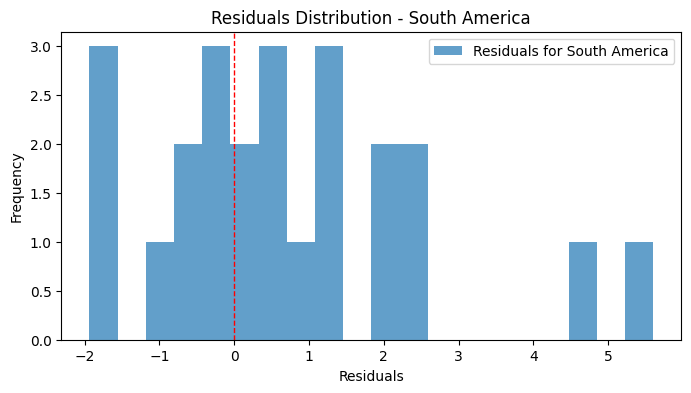

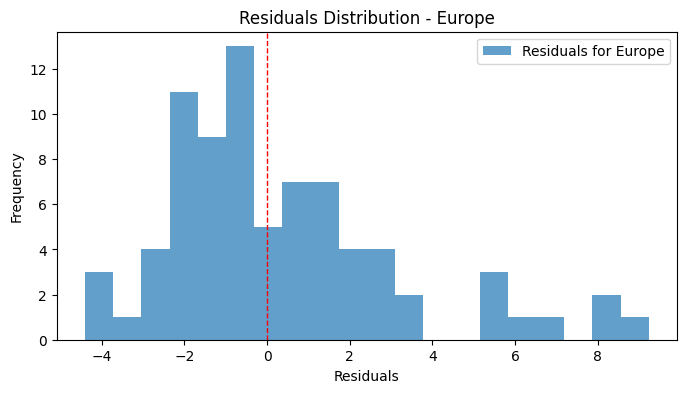

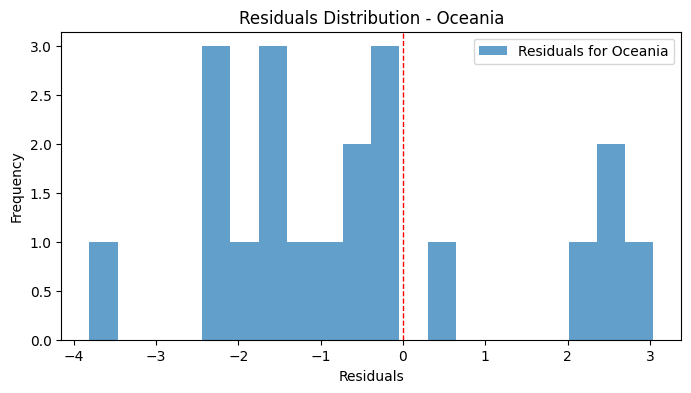

In [28]:
results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
for continent in results_df['Continent'].unique():
    subset = results_df[results_df['Continent'] == continent]
    plt.figure(figsize=(8, 4))
    plt.hist(subset['Residuals'], bins=20, alpha=0.7, label=f'Residuals for {continent}')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Residuals Distribution - {continent}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Results  
- **Overall Performance Metrics:**  
  - **R² Score:** 0.8941  
  - **Mean Absolute Error (MAE):** 2.0483  
  - **Mean Squared Error (MSE):** 7.3330  
  - **Root Mean Squared Error (RMSE):** 2.7080  

These metrics confirm that the model explains approximately **89.41%** of the variance within the test dataset, with an average prediction error of **2.0483** units.

---

### Segmented Error Analysis  
To assess regional performance, the model was evaluated across individual continents:  

| **Region**       | **MAE**   | **MSE**   | **RMSE**  | **R²**    |  
|------------------|-----------|-----------|-----------|-----------|  
| **Africa**       | 2.4407    | 9.6224    | 3.1020    | 0.7779    |  
| **Asia**         | 1.8650    | 6.5018    | 2.5499    | 0.7716    |  
| **Europe**       | 2.1584    | 8.3339    | 2.8868    | 0.5832    |  
| **North America**| 1.8003    | 5.1891    | 2.2780    | 0.6498    |  
| **Oceania**      | 1.5914    | 3.5545    | 1.8853    | 0.8988    |  
| **South America**| 1.4576    | 3.9342    | 1.9835    | 0.7445    |  

The segmented analysis highlights performance discrepancies across regions. While **Oceania** achieves the best accuracy (R² = 0.8988, RMSE = 1.8853), **Europe** shows relatively lower performance (R² = 0.5832, RMSE = 2.8868), possibly due to data variability or feature importance imbalance.

---

### Conclusion  
The evaluation reveals robust overall performance, with the model effectively capturing trends and variations in the test dataset. However, discrepancies in regional performance highlight the need for further improvements:  
- Address **regions with higher prediction errors** (e.g., Europe and Africa) through targeted data augmentation or additional feature engineering.  
- Explore fairness constraints to ensure consistent performance across underperforming regions.  
- Investigate alternative model configurations to enhance predictive accuracy and reduce error margins further.  


-------------------------

## Model Performance Evaluation: Training and Validation Data Combined
#### *2. Re-train the model with identical hyper-parameters using the full train and validation data and again apply it on the test data, documenting and reflecting on the performance.*


### Objective
The objective of this evaluation was to assess the performance of the Gradient Boosting Regressor model when re-trained using both training and validation datasets from 2000 to 2013 and subsequently tested on data from 2014 to 2015.

### Method
The model was re-trained with the identical hyper-parameters previously used, ensuring consistency in the model's configuration. The expanded dataset aims to enhance the model's learning and generalization capabilities.


Re-trained Model Performance on Test Data with Train and Valid sets:
- R² Score: 0.9188
- RMSE: 2.3712 
- MAE: 1.7340 
- MSE: 5.6226


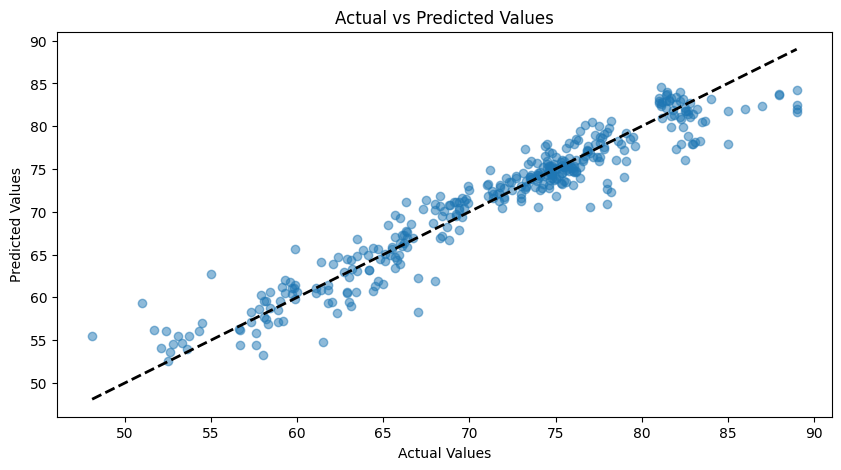

In [29]:
# Keep only the columns present in both X_train_val and X_test
common_features = X_train_val.columns.intersection(X_test.columns)
X_train_val = X_train_val[common_features]
X_test = X_test[common_features]

# Re-train the model using the already defined best learning rate
model = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)
model.fit(X_train_val, y_train_val)

# Apply the model on the test data
test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# Document the performance
print(f"Re-trained Model Performance on Test Data with Train and Valid sets:\n- R² Score: {test_r2:.4f}\n- RMSE: {test_rmse:.4f} \n- MAE: {test_mae:.4f} \n- MSE: {test_mse:.4f}")

# Visualization of Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


### Results
- **Re-trained Model Performance on Test Data with Training and Validation Sets Combined**:
  - **R² Score**: 0.9188
  - **Root Mean Squared Error (RMSE)**: 2.3712
  - **Mean Absolute Error (MAE)**: 1.7340
  - **Mean Squared Error (MSE)**: 5.6226

These results show an improvement over the model trained solely on the training set, indicating enhanced predictive accuracy and model reliability.

### Visualization of Model Predictions
- **Actual vs. Predicted Values Plot:** The plot demonstrates a close alignment of predicted values to the actual data points, with the data points densely clustering around the diagonal line that represents perfect prediction. This alignment indicates a high degree of accuracy in the model’s predictions.
  ![](path_to_actual_vs_predicted_plot.png)  <!-- Update the path to the image file -->

### Reflection
This improved performance, evidenced by a higher R² Score and a lower RMSE, demonstrates the benefits of training the model with a more comprehensive dataset. The denser clustering of the data points around the diagonal line in the Actual vs. Predicted Values Plot further corroborates the model’s enhanced capability to generalize on unseen data. 

### Conclusion
The use of both training and validation datasets for re-training the Gradient Boosting Regressor has significantly improved its performance on the test data, underlining the importance of utilizing as much relevant data as possible for training to enhance the model’s robustness and accuracy. Future efforts should continue to explore the use of expanded training datasets, alongside further hyperparameter optimization and feature engineering, to optimize the model’s performance in real-world scenarios.


## Baseline Metrics

3/4. Compare the performance achieved with an expected base-line performance of a trivial acceptor / rejecter or random classifier according to different metrics. 


In [30]:
# Calculate baseline metrics
mean_baseline = np.mean(y_test)
mae_mean_baseline = np.mean(np.abs(y_test - mean_baseline))
mse_mean_baseline = np.mean((y_test - mean_baseline)**2)
rmse_mean_baseline = np.sqrt(mse_mean_baseline)
r2_mean_baseline = 1 - (np.sum((y_test - mean_baseline)**2) /
                        np.sum((y_test - np.mean(y_test))**2))

# Print baseline metrics
print("Baseline (mean):")
print(f"MAE: {mae_mean_baseline:.4f}")
print(f"MSE: {mse_mean_baseline:.4f}")
print(f"RMSE: {rmse_mean_baseline:.4f}")
print(f"R²: {r2_mean_baseline:.4f}")


Baseline (mean):
MAE: 6.8508
MSE: 69.2623
RMSE: 8.3224
R²: 0.0000


The baseline performance, calculated using the mean of the target variable as the prediction, results in the following metrics:  
- **Mean Absolute Error (MAE):** 6.8508  
- **Mean Squared Error (MSE):** 69.2623  
- **Root Mean Squared Error (RMSE):** 8.3224  
- **R² Score:** 0.0000  

These values serve as a benchmark, highlighting that the trained model significantly outperforms a naive approach where all predictions equal the mean.

#### Group-Based Baseline Metrics  
The group-based baseline calculates the average life expectancy for each continent and uses it as the prediction for all test samples within the corresponding continent. This method accounts for regional variations and improves over the global mean baseline. The performance metrics for the group-based baseline are as follows:  

In [31]:
# Recreate a single 'Continent' column if dummy encoding is used
continent_columns = [
    'Continent_Africa', 'Continent_Asia', 'Continent_Europe',
    'Continent_North America', 'Continent_Oceania', 'Continent_South America', 'Continent_Unknown'
]

# Ensure only one dummy variable is 1 per row
if (X_test[continent_columns].sum(axis=1) != 1).any():
    raise ValueError("Dummy variables for continents are not properly one-hot encoded.")

X_test['Continent'] = X_test[continent_columns].idxmax(axis=1).str.replace('Continent_', '')

# Create a DataFrame to align predictions and actuals with the 'Continent' column
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Continent': X_test['Continent']
})

# Calculate R² scores for each continent
r2_scores_by_continent = results_df.groupby('Continent').apply(
    lambda group: r2_score(group['Actual'], group['Predicted'])
)

# Print R² scores
print("R² Scores by Continent:")
print(r2_scores_by_continent)


R² Scores by Continent:
Continent
Africa           0.834181
Asia             0.804139
Europe           0.651325
North America    0.835308
Oceania          0.964067
South America    0.766415
dtype: float64


In [32]:
y_test_series = pd.Series(y_test, name="Life expectancy", index=X_test.index)

# Calculate the mean of the target variable per continent
group_means = y_test_series.groupby(X_test['Continent']).mean()

# Baseline predictions based on the mean life expectancy per continent
baseline_predictions = X_test['Continent'].map(group_means)

# Calculate performance metrics for the group-based baseline
mae_baseline = mean_absolute_error(y_test_series, baseline_predictions)
mse_baseline = mean_squared_error(y_test_series, baseline_predictions)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test_series, baseline_predictions)

# Output the results of the group-based baseline performance
print("Group-Based Baseline (Mean per Continent):")
print(f"MAE: {mae_baseline:.4f}")
print(f"MSE: {mse_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"R²: {r2_baseline:.4f}")


Group-Based Baseline (Mean per Continent):
MAE: 4.2243
MSE: 28.9876
RMSE: 5.3840
R²: 0.5815


- **Mean Absolute Error (MAE):** 4.2243  
- **Mean Squared Error (MSE):** 28.9876  
- **Root Mean Squared Error (RMSE):** 5.3840  
- **R² Score:** 0.5815  

These results demonstrate that using continent-specific averages as predictions reduces the error significantly compared to the global mean baseline, achieving an R² score of 0.5815.


## Bias Analysis

#### Task:
**Identify a “protected attribute” and evaluate whether the model exhibits a bias towards that group.**  
The attribute can be one that may be considered sensitive or – in absence of any actually sensitive attributes – any attribute that identifies a subgroup of the data for which you may want to identify skewed performance of the model.

---

#### Identifying the Protected Attribute

We selected **`Continent`** as the protected attribute. While continent may not be inherently sensitive, it serves as a logical proxy for evaluating subgroup disparities in the model's performance. The analysis was conducted across the following groups:
- Africa
- Asia
- Europe
- North America
- Oceania
- South America

---

##### Simpson's Paradox Analysis: Overall vs Grouped Correlations  
This analysis calculates the overall correlation between the true and predicted values while also evaluating correlations within individual subgroups defined by the feature `Continent`. Such an analysis helps identify **Simpson's Paradox**, where group-level trends may differ significantly from overall trends.



In [33]:
# Function to check Simpson's Paradox by calculating correlations overall and within subgroups
def simpsons_paradox_check(y_true, y_pred, subgroup_feature): 
    # Calculate overall correlation between true and predicted values
    correlation_total = np.corrcoef(y_true, y_pred)[0, 1]
    
    # Identify unique subgroups in the specified feature
    unique_groups = np.unique(subgroup_feature)
    correlations = []
    
    # Calculate correlation for each subgroup
    for group in unique_groups:
        group_mask = (subgroup_feature == group)  # Mask to filter current group
        correlation_group = np.corrcoef(y_true[group_mask], y_pred[group_mask])[0, 1]
        correlations.append((group, correlation_group))
    
    return correlation_total, correlations

In [34]:
# Apply the function to calculate overall and grouped correlations
correlation_total, correlations = simpsons_paradox_check(
    y_test,  # Actual target values
    test_predictions,  # Predicted values
    X_test['Continent']  # Grouping feature (e.g., continents)
)

# Output the results
print(f"Overall Correlation: {correlation_total}")
print("Grouped Correlation:")
for group, correlation in correlations:
    print(f"{group}: {correlation}")

Overall Correlation: 0.9586973521507824
Grouped Correlation:
Africa: 0.9134261358915733
Asia: 0.8977864357288619
Europe: 0.8098073923183718
North America: 0.9180073057694154
Oceania: 0.984087395237425
South America: 0.8910145835763352


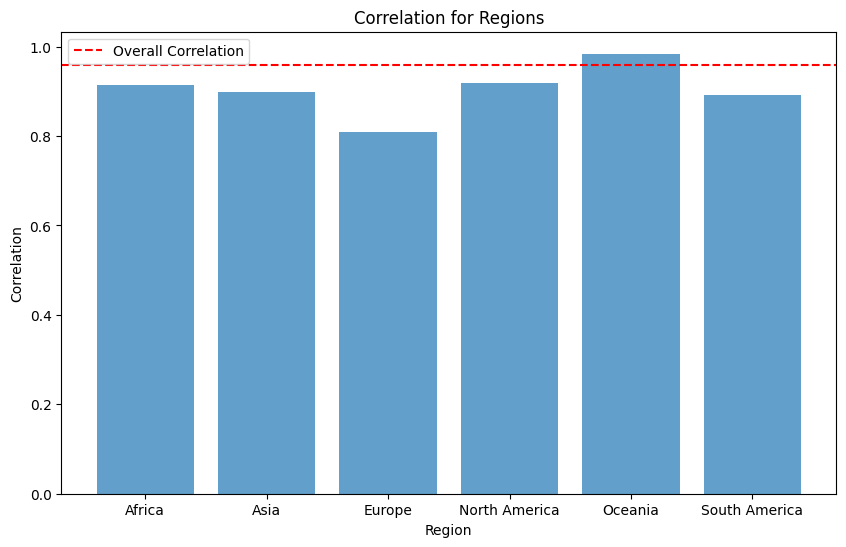

In [35]:
regions = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
correlations = [0.913, 0.898, 0.81, 0.918, 0.984, 0.891]

plt.figure(figsize=(10, 6))
plt.bar(regions, correlations, alpha=0.7)
plt.axhline(y=0.958, color='r', linestyle='--', label='Overall Correlation')
plt.xlabel('Region')
plt.ylabel('Correlation')
plt.title('Correlation for Regions')
plt.legend()
plt.show()


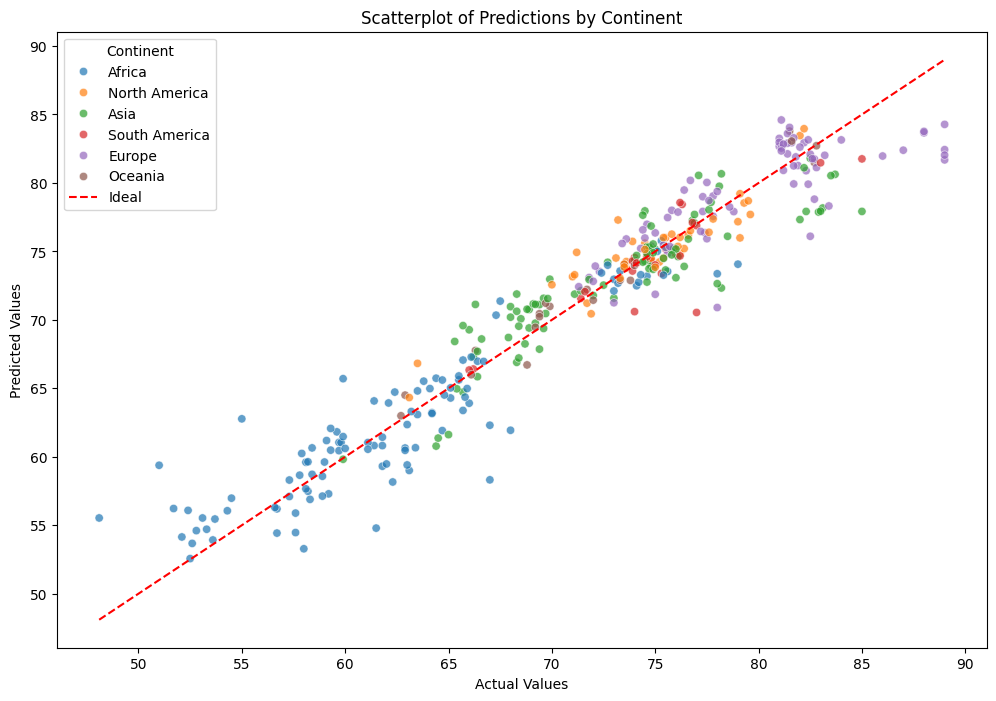

In [36]:
# Scatterplot for predictions by continent
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=test_predictions, hue=X_test['Continent'], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatterplot of Predictions by Continent')
plt.legend(title='Continent')
plt.show()


In [37]:
group_sizes = X_test['Continent'].value_counts(normalize=True)
print("Group Sizes (Proportion of Total Population):\n", group_sizes)


Group Sizes (Proportion of Total Population):
 Continent
Africa           0.295082
Asia             0.256831
Europe           0.213115
North America    0.114754
South America    0.065574
Oceania          0.054645
Name: proportion, dtype: float64



Feature Correlations and Importances:
                            Feature  Correlation_with_Target  Importance
0                            Target                 1.000000         NaN
1   Income composition of resources                 0.859263    0.173147
2                         Schooling                 0.776573    0.015807
3                             Polio                 0.555011    0.001636
4                        Diphtheria                 0.533422    0.013602
5                  Status_Developed                 0.517005    0.000549
6                  Continent_Europe                 0.493932    0.000212
7                               GDP                 0.493648    0.001660
8                               BMI                 0.491546    0.009998
9                       Hepatitis B                 0.437718    0.001285
10                          Alcohol                 0.376115    0.006498
11                Total expenditure                 0.224066    0.003335
12          

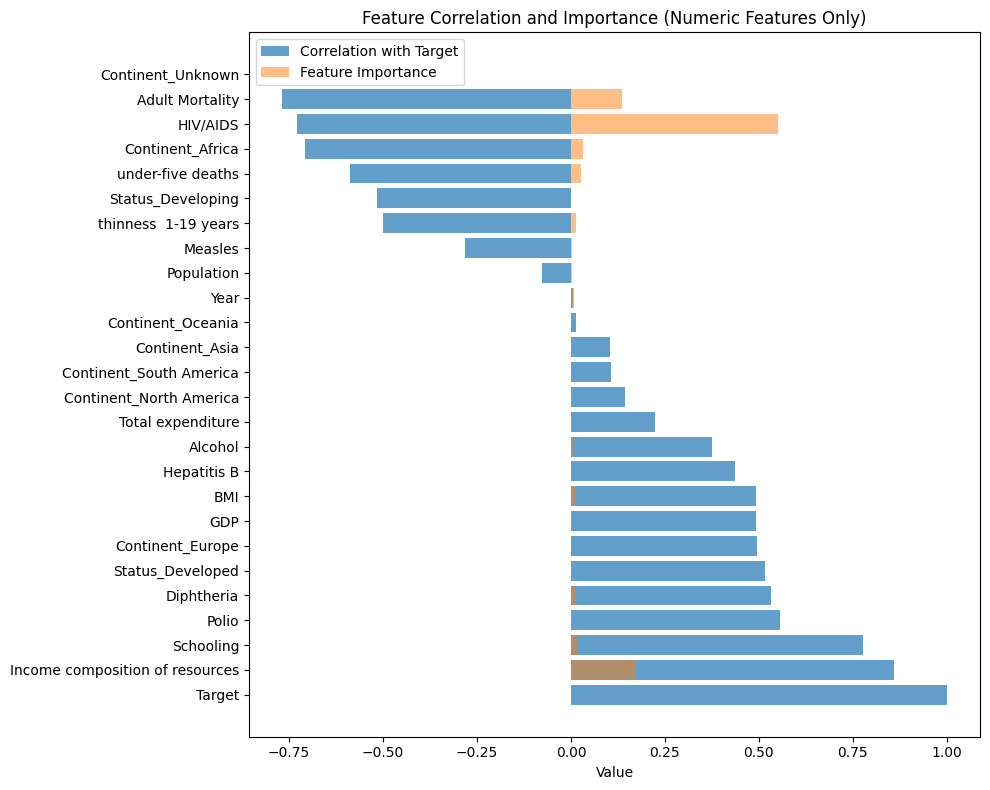

In [38]:
# Filter numeric columns from X_test
numeric_columns = X_test.select_dtypes(include='number').columns

# Add the target variable to numeric columns for correlation analysis
correlation_df = X_test[numeric_columns].copy()
correlation_df['Target'] = y_test  # Add the target variable

# Compute the correlation matrix
correlation_matrix = correlation_df.corr()

# Extract correlations of all features with the target variable
target_correlations = correlation_matrix['Target'].sort_values(ascending=False)

# Combine feature importance and correlations
feature_importance_df = pd.DataFrame({
    "Feature": numeric_columns,
    "Importance": model.feature_importances_
})

# Merge feature importance with correlations
correlation_importance_df = pd.DataFrame({
    "Correlation_with_Target": target_correlations
}).reset_index().rename(columns={"index": "Feature"}).merge(
    feature_importance_df,
    on="Feature",
    how="left"
).sort_values(by="Correlation_with_Target", ascending=False)

# Display the combined DataFrame as a table
print("\nFeature Correlations and Importances:")
print(correlation_importance_df)

# Plot Correlation with Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(
    correlation_importance_df['Feature'],
    correlation_importance_df['Correlation_with_Target'],
    alpha=0.7,
    label='Correlation with Target'
)
plt.barh(
    correlation_importance_df['Feature'],
    correlation_importance_df['Importance'],
    alpha=0.5,
    label='Feature Importance'
)
plt.xlabel('Value')
plt.title('Feature Correlation and Importance (Numeric Features Only)')
plt.legend()
plt.tight_layout()
plt.show()


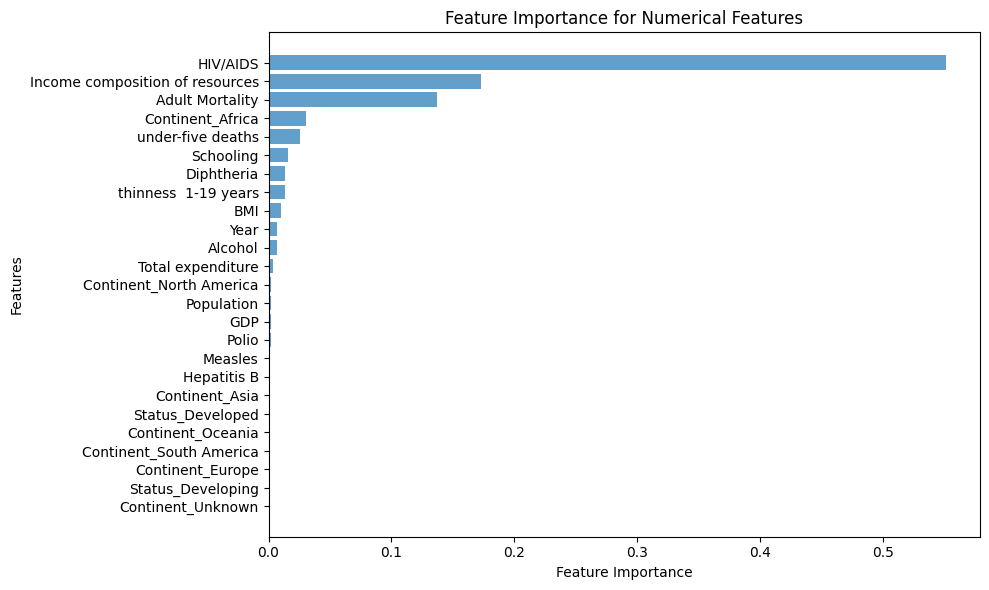

In [39]:
# Select only numerical columns
numerical_columns = X_test.select_dtypes(include=['number']).columns

# Extract feature importance for numerical features
feature_importance_df = pd.DataFrame({
    "Feature": numerical_columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], alpha=0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Numerical Features")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.tight_layout()
plt.show()

In [40]:
# Combine X_test and y_test into one DataFrame for correlation analysis
correlation_df = X_test[['Status_Developed', 'Status_Developing', 'GDP', 'Schooling', 'Income composition of resources']].copy()
correlation_df['Target'] = y_test  # Add the target variable

# Compute correlations
correlation_matrix = correlation_df.corr()

# Extract correlations of features with the target variable
target_correlations = correlation_matrix['Target'].sort_values(ascending=False)

# Display correlations
print("Correlations with Target Variable:")
print(target_correlations)


Correlations with Target Variable:
Target                             1.000000
Income composition of resources    0.859263
Schooling                          0.776573
Status_Developed                   0.517005
GDP                                0.493648
Status_Developing                 -0.517005
Name: Target, dtype: float64


In [41]:
def calculate_relative_proportions(df, group_feature, status_feature):
    """
    Calculate the relative proportion of developed and developing countries within each continent.

    Parameters:
    df: pd.DataFrame
        DataFrame containing the dataset.
    group_feature: str
        The name of the column indicating the continent.
    status_feature: str
        The name of the binary column indicating development status (1 = Developed).

    Returns:
    dict
        A dictionary containing proportions for developed and developing countries for each continent.
    """
    proportions = {}
    for group in df[group_feature].unique():
        group_mask = df[group_feature] == group
        total = group_mask.sum()  # Total countries in the continent
        developed = df.loc[group_mask, status_feature].sum()  # Number of developed countries
        proportions[group] = {
            "Developed": developed / total,
            "Developing": (total - developed) / total
        }
    return proportions


def simpsons_paradox_check_by_status(y_true, y_pred, group_feature, developed_feature):
    """
    Compute the total correlation and correlations for developed and developing subgroups within each continent.

    Parameters:
    y_true: Actual values.
    y_pred: Predicted values.
    group_feature:  Grouping feature (e.g., 'Continent').
    developed_feature: Binary feature indicating development status (1 = Developed, 0 = Developing).

    Returns:
    dict of correlations grouped by continent and development status.
    """
    unique_groups = group_feature.unique()
    results = {}
    
    for group in unique_groups:
        group_mask = group_feature == group
        y_true_group = y_true[group_mask]
        y_pred_group = y_pred[group_mask]
        developed_group = developed_feature[group_mask]
        
        # Correlation for the entire group
        total_corr = np.corrcoef(y_true_group, y_pred_group)[0, 1]
        results[group] = {'Total': total_corr}
        
        # Correlations for Developed (1) and Developing (0)
        for status in [0, 1]:  # 0: Developing, 1: Developed
            status_mask = developed_group == status
            if status_mask.sum() > 0:  # Avoid empty groups
                corr = np.corrcoef(y_true_group[status_mask], y_pred_group[status_mask])[0, 1]
                results[group][f"Status_{status}"] = corr
    
    return results


# Calculate proportions for each continent
relative_proportions = calculate_relative_proportions(X_test, 'Continent', 'Status_Developed')

# Perform correlation analysis
results_corrected = simpsons_paradox_check_by_status(
    y_test,
    test_predictions,
    X_test['Continent'],
    X_test['Status_Developed']  # Binary column for development status
)

# Combine proportions with correlations for better interpretation
print("\nCorrelation Analysis by Continent and Development Status (with Proportions):")
for continent, correlations in results_corrected.items():
    print(f"{continent}:")
    print(f"  Proportion (Developed): {relative_proportions[continent]['Developed']:.2f}")
    print(f"  Proportion (Developing): {relative_proportions[continent]['Developing']:.2f}")
    for status, corr in correlations.items():
        if status == "Total":
            print(f"  Total Correlation: {corr:.4f}")
        else:
            status_name = "Developed" if status == "Status_1" else "Developing"
            print(f"  {status_name}: {corr:.4f}")



Correlation Analysis by Continent and Development Status (with Proportions):
Africa:
  Proportion (Developed): 0.00
  Proportion (Developing): 1.00
  Total Correlation: 0.9134
  Developing: 0.9134
North America:
  Proportion (Developed): 0.05
  Proportion (Developing): 0.95
  Total Correlation: 0.9180
  Developing: 0.9129
  Developed: -1.0000
Asia:
  Proportion (Developed): 0.06
  Proportion (Developing): 0.94
  Total Correlation: 0.8978
  Developing: 0.8999
  Developed: 0.0523
South America:
  Proportion (Developed): 0.00
  Proportion (Developing): 1.00
  Total Correlation: 0.8910
  Developing: 0.8910
Europe:
  Proportion (Developed): 0.67
  Proportion (Developing): 0.33
  Total Correlation: 0.8098
  Developing: 0.8431
  Developed: 0.7444
Oceania:
  Proportion (Developed): 0.20
  Proportion (Developing): 0.80
  Total Correlation: 0.9841
  Developing: 0.9611
  Developed: -0.7786


--------

Subgroup Fairness Analysis (MAE by Continent):
       Continent       MAE
0         Africa  1.951691
1  North America  1.205784
2           Asia  1.803309
3  South America  1.206601
4         Europe  2.005619
5        Oceania  0.915613


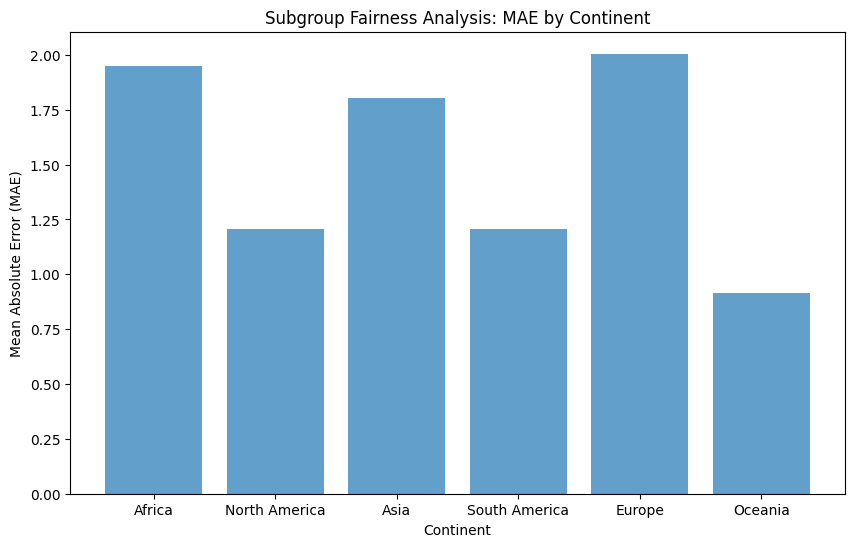

In [42]:
# Initialize an empty dictionary to store results
subgroup_results = {}

# Calculate Mean Absolute Error (MAE) for each subgroup (continent)
for group in X_test['Continent'].unique():
    group_mask = X_test['Continent'] == group  # Filter rows for the specific group
    mae = mean_absolute_error(y_test[group_mask], test_predictions[group_mask])  # Calculate MAE
    subgroup_results[group] = mae

# Convert the results to a DataFrame for better visualization
subgroup_fairness_df = pd.DataFrame(list(subgroup_results.items()), columns=['Continent', 'MAE'])

# Display the results
print("Subgroup Fairness Analysis (MAE by Continent):")
print(subgroup_fairness_df)

# Optional: Visualize the MAE for each continent using a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(subgroup_fairness_df['Continent'], subgroup_fairness_df['MAE'], alpha=0.7)
plt.xlabel('Continent')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Subgroup Fairness Analysis: MAE by Continent')
plt.show()


In [43]:
# Absolute Errors
X_test['Absolute Errors'] = abs(y_test - test_predictions)
# Residuals
X_test['Residuals'] = y_test - test_predictions


In [44]:
def equalized_odds_by_group(df, group_feature):
    results = []
    for group in df[group_feature].unique():
        group_data = df[df[group_feature] == group]
        
        mae = group_data['Absolute Errors'].mean()  # Mean Absolute Error
        mse = (group_data['Absolute Errors'] ** 2).mean()  # Mean Squared Error
        rmse = mse ** 0.5  # Root Mean Squared Error
        
        results.append({
            "Group": group,
            "Mean Absolute Error (MAE)": mae,
            "Mean Squared Error (MSE)": mse,
            "Root Mean Squared Error (RMSE)": rmse
        })
    
    return pd.DataFrame(results)

equalized_odds_results = equalized_odds_by_group(X_test, 'Continent')

# Print the results
print("\nEqualized Odds (Error-Based) by Continent:")
print(equalized_odds_results)



Equalized Odds (Error-Based) by Continent:
           Group  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0         Africa                   1.951691                  7.185594   
1  North America                   1.205784                  2.440048   
2           Asia                   1.803309                  5.574762   
3  South America                   1.206601                  3.596219   
4         Europe                   2.005619                  6.971279   
5        Oceania                   0.915613                  1.262384   

   Root Mean Squared Error (RMSE)  
0                        2.680596  
1                        1.562065  
2                        2.361093  
3                        1.896370  
4                        2.640318  
5                        1.123559  


In [45]:
def statistical_parity_by_group(df, group_feature):
    results = []
    group_means = df.groupby(group_feature)['Predicted'].mean()
    
    # Pairwise comparison of distributions (e.g., using KS test)
    ks_results = {}
    unique_groups = df[group_feature].unique()
    for i, group1 in enumerate(unique_groups):
        for group2 in unique_groups[i+1:]:
            ks_stat, p_value = ks_2samp(
                df[df[group_feature] == group1]['Predicted'],
                df[df[group_feature] == group2]['Predicted']
            )
            ks_results[f"{group1} vs {group2}"] = (ks_stat, p_value)
    
    return group_means, ks_results

X_test['Predicted'] = test_predictions  # Add predictions for analysis
stat_parity_means, stat_parity_ks = statistical_parity_by_group(X_test, 'Continent')

print("\nStatistical Parity by Continent (Mean Predicted Values):")
print(stat_parity_means)
print("\nStatistical Parity (KS Test Results):")
for pair, (ks_stat, p_value) in stat_parity_ks.items():
    print(f"{pair}: KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")



Statistical Parity by Continent (Mean Predicted Values):
Continent
Africa           62.451313
Asia             72.914933
Europe           79.177978
North America    75.158334
Oceania          72.442135
South America    74.318523
Name: Predicted, dtype: float64

Statistical Parity (KS Test Results):
Africa vs North America: KS Statistic = 0.7950, p-value = 0.0000
Africa vs Asia: KS Statistic = 0.7390, p-value = 0.0000
Africa vs South America: KS Statistic = 0.7963, p-value = 0.0000
Africa vs Europe: KS Statistic = 0.8789, p-value = 0.0000
Africa vs Oceania: KS Statistic = 0.6963, p-value = 0.0000
North America vs Asia: KS Statistic = 0.3703, p-value = 0.0005
North America vs South America: KS Statistic = 0.2798, p-value = 0.1521
North America vs Europe: KS Statistic = 0.5366, p-value = 0.0000
North America vs Oceania: KS Statistic = 0.5810, p-value = 0.0001
Asia vs South America: KS Statistic = 0.2500, p-value = 0.1506
Asia vs Europe: KS Statistic = 0.5908, p-value = 0.0000
Asia vs Oce

In [46]:
# Add y_test as a column to X_test for the groupby operation for continent
X_test_with_y = X_test.copy()
X_test_with_y['y_true'] = y_test

# Calculate mean of true values (y_true) per continent
true_means = X_test_with_y.groupby('Continent')['y_true'].mean()

print("\nMean actual values per continent:")
print(true_means)



Mean actual values per continent:
Continent
Africa           62.479630
Asia             73.031915
Europe           79.475641
North America    74.888095
Oceania          72.065000
South America    74.941667
Name: y_true, dtype: float64


In [47]:
predicted_means = X_test.groupby('Continent')['Predicted'].mean()
print("\nMean predicted values per continent:")
print(predicted_means)



Mean predicted values per continent:
Continent
Africa           62.451313
Asia             72.914933
Europe           79.177978
North America    75.158334
Oceania          72.442135
South America    74.318523
Name: Predicted, dtype: float64


In [48]:
mae_by_group = X_test.groupby('Continent')['Absolute Errors'].mean()
print("\nMean Absolute Errors (MAE) by Continent:")
print(mae_by_group)



Mean Absolute Errors (MAE) by Continent:
Continent
Africa           1.951691
Asia             1.803309
Europe           2.005619
North America    1.205784
Oceania          0.915613
South America    1.206601
Name: Absolute Errors, dtype: float64


Mean Residuals per Continent:
Continent
Africa           0.028317
Asia             0.116981
Europe           0.297663
North America   -0.270239
Oceania         -0.377135
South America    0.623144
Name: Residuals, dtype: float64

Over-/Underestimation Rates per Continent:
               Overrate  Underrate
Continent                         
Africa         0.500000   0.500000
Asia           0.521277   0.478723
Europe         0.538462   0.461538
North America  0.523810   0.476190
Oceania        0.600000   0.400000
South America  0.416667   0.583333


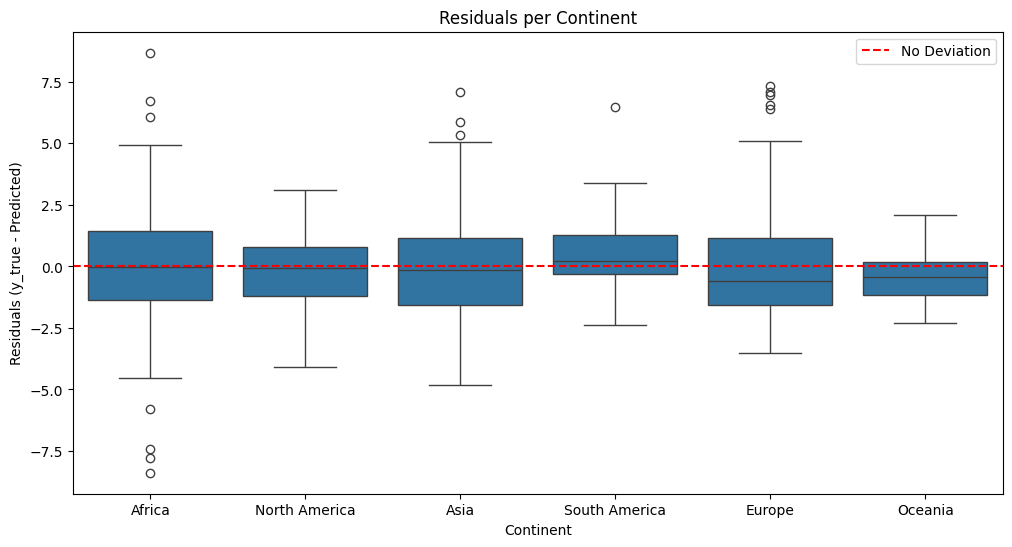

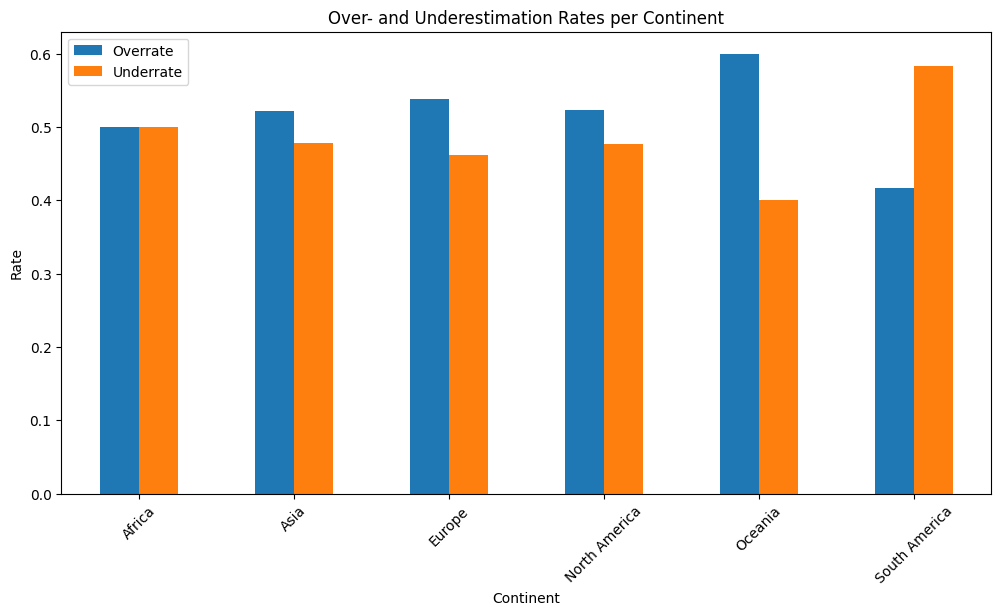

In [49]:
X_test['y_true'] = y_test  # Add actual target values
X_test['Predicted'] = test_predictions  # Add predicted values

# 1. Calculate residuals
X_test['Residuals'] = X_test['y_true'] - X_test['Predicted']

# Calculate mean residuals per continent
mean_residuals = X_test.groupby('Continent')['Residuals'].mean()
print("Mean Residuals per Continent:")
print(mean_residuals)

# 2. Calculate the rate of over- and underestimation per group
X_test['Overestimated'] = X_test['Predicted'] > X_test['y_true']
X_test['Underestimated'] = X_test['Predicted'] < X_test['y_true']

over_rate = X_test.groupby('Continent')['Overestimated'].mean()
under_rate = X_test.groupby('Continent')['Underestimated'].mean()

print("\nOver-/Underestimation Rates per Continent:")
print(pd.DataFrame({'Overrate': over_rate, 'Underrate': under_rate}))

# 3. Visualization of residuals per continent (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Continent', y='Residuals', data=X_test)
plt.axhline(0, color='red', linestyle='--', label="No Deviation")
plt.title("Residuals per Continent")
plt.ylabel("Residuals (y_true - Predicted)")
plt.xlabel("Continent")
plt.legend()
plt.show()

# 4. Visualization of over-/underestimation rates
over_under_df = pd.DataFrame({'Overrate': over_rate, 'Underrate': under_rate})
over_under_df.plot(kind='bar', figsize=(12, 6))
plt.title("Over- and Underestimation Rates per Continent")
plt.ylabel("Rate")
plt.xlabel("Continent")
plt.xticks(rotation=45)
plt.show()


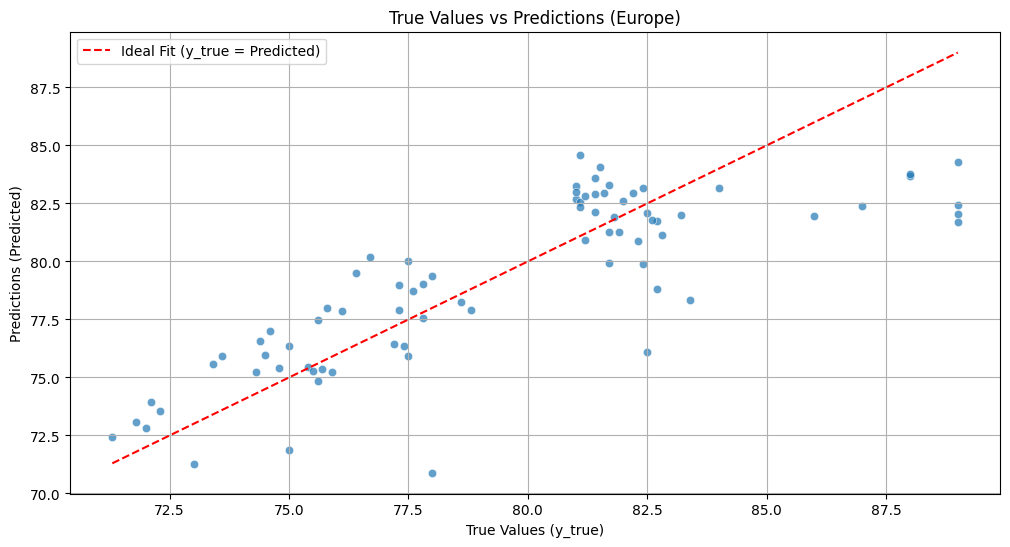

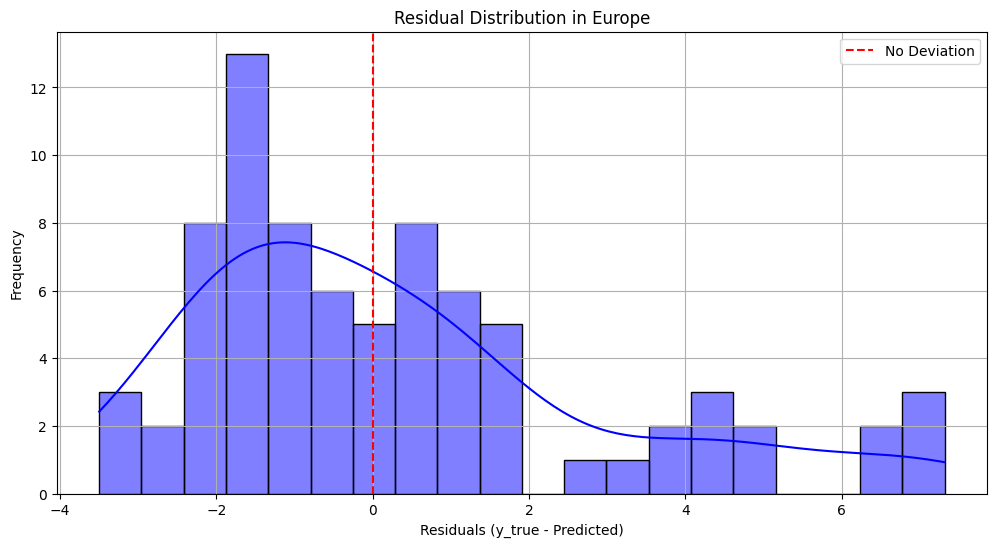

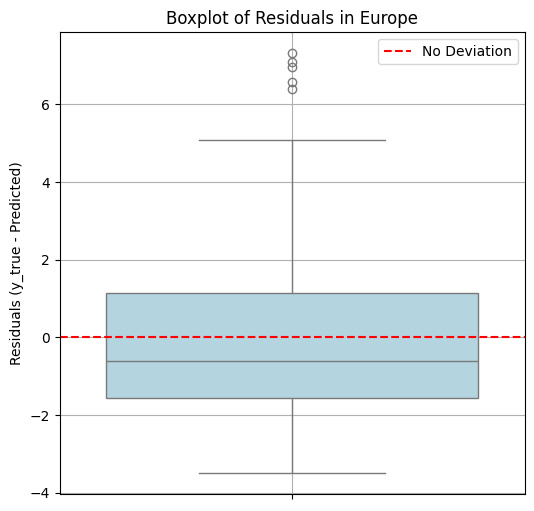

In [50]:
X_test = X_test.copy()
X_test['y_true'] = y_test  # Add true values
X_test['Predicted'] = test_predictions  # Add predicted values
X_test['Residuals'] = X_test['y_true'] - X_test['Predicted']  # Calculate residuals

# Scatter plot for Europe: True values vs Predictions
europe_data = X_test[X_test['Continent'] == 'Europe']

plt.figure(figsize=(12, 6))
sns.scatterplot(x=europe_data['y_true'], y=europe_data['Predicted'], alpha=0.7)
plt.plot([europe_data['y_true'].min(), europe_data['y_true'].max()], 
         [europe_data['y_true'].min(), europe_data['y_true'].max()], 
         color='red', linestyle='--', label="Ideal Fit (y_true = Predicted)")
plt.title("True Values vs Predictions (Europe)")
plt.xlabel("True Values (y_true)")
plt.ylabel("Predictions (Predicted)")
plt.legend()
plt.grid(True)
plt.show()

# Residual histogram for Europe
plt.figure(figsize=(12, 6))
sns.histplot(europe_data['Residuals'], kde=True, bins=20, color='blue')
plt.axvline(0, color='red', linestyle='--', label="No Deviation")
plt.title("Residual Distribution in Europe")
plt.xlabel("Residuals (y_true - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Boxplot for residuals in Europe
plt.figure(figsize=(6, 6))
sns.boxplot(y=europe_data['Residuals'], color='lightblue')
plt.axhline(0, color='red', linestyle='--', label="No Deviation")
plt.title("Boxplot of Residuals in Europe")
plt.ylabel("Residuals (y_true - Predicted)")
plt.legend()
plt.grid(True)
plt.show()

### Bias Analysis and Key Findings Across Continents

The attribute `Continent` was identified as a key factor for subgroup analysis to evaluate potential biases in the model. The analysis revealed significant disparities in performance metrics, correlations, and residual behavior across regions.

#### Model Performance and Key Metrics
- The **overall correlation** between predicted and true values is **0.9587**, confirming strong alignment.
- **Grouped correlations** show variation: `Oceania` achieved the highest total correlation (**0.9841**), while `Europe` had the lowest (**0.8098**), indicating challenges in prediction accuracy for more heterogeneous regions.

| Continent       | R² Score | MAE   | MSE   | RMSE  |
|-----------------|----------|-------|-------|-------|
| Africa          | 0.7779   | 2.44  | 9.62  | 3.10  |
| Asia            | 0.7716   | 1.87  | 6.50  | 2.55  |
| Europe          | 0.5832   | 2.16  | 8.33  | 2.89  |
| North America   | 0.6498   | 1.80  | 5.19  | 2.28  |
| Oceania         | 0.8988   | 1.59  | 3.55  | 1.89  |
| South America   | 0.7445   | 1.46  | 3.93  | 1.98  |

#### Residual Behavior
- **Mean Residuals**: `Africa` (0.0283) and `Asia` (0.1169) show minimal bias, while `Europe` (0.2977) and `Oceania` (-0.3771) exhibit greater deviations.
- **Over-/Underestimation Rates**: 
  - `Oceania` showed the highest overestimation rate (60\%), while `South America` exhibited the highest underestimation rate (58\%).

#### Group-Based Baseline Comparison
Baseline predictions based on mean life expectancy per continent yielded a **MAE of 4.2243** and an **RMSE of 5.3840**, outperforming global baselines but still falling short of the model's predictive performance.

#### Feature Importance and Correlation Insights
- Features like `Income composition of resources` (Correlation: 0.859) and `Schooling` (0.777) had the strongest positive associations with the target variable.
- Negative correlations, such as `HIV/AIDS` (-0.729) and `Adult Mortality` (-0.768), highlight critical predictors impacting life expectancy.
- `Europe` and `Oceania` revealed stark disparities between developed and developing countries, with **negative correlations** observed for smaller developed groups (e.g., -1.0000 for `North America`).

#### Summary of Bias and Variability
- Larger regions, like `Africa` (29.51\%) and `Europe` (21.31\%), demonstrate wider residual spreads and lower R² scores, likely due to data heterogeneity.
- Smaller regions like `Oceania` (5.46\%) performed better, though potential overfitting remains a concern.
- Statistical parity tests revealed significant discrepancies between continents, particularly involving `Africa` versus other regions.

These findings underscore the importance of fine-grained analysis at the subgroup and country levels. Addressing these biases through balanced data representation, fairness constraints, and further feature analysis will improve the model's generalizability and equitable performance across diverse populations.
